# Python2 Notebook for Text Detection in Scene or Document

In [1]:
%matplotlib inline
import keras
import tensorflow as tf
import numpy as np 
import cv2
from matplotlib import pyplot
import os
import sys
np.set_printoptions(3, suppress=True)
print "keras.version =", keras.__version__
print "tensorflow.version =", tf.__version__

Using TensorFlow backend.


keras.version = 2.0.7
tensorflow.version = 1.1.0


# Set Text Detection Path

In [2]:
repo_root = os.path.join( os.getcwd(), os.path.pardir )
print "git repo root =", repo_root
assert os.path.isdir( repo_root ), "ERROR: can't locate git repo for text detection"
model_dir = os.path.join( repo_root, 'model' )
scriptID_weight = os.path.join( model_dir, 'sciptIDModel.h5' )
assert os.path.isfile( scriptID_weight ), "ERROR: can't locate script-ID classification model"
textDet_weight  = os.path.join( model_dir, 'textDetModel.h5' )
assert os.path.isfile( textDet_weight ), "ERROR: can't locate text detection model"

data_dir  = os.path.join( repo_root, 'data' )
lib_dir   = os.path.join( repo_root, 'lib' )
sys.path.insert( 0, lib_dir )
import textDetCore

git repo root = /nas/medifor/yue_wu/thirdparty/TextDetWithScriptID/notebook/..


# Load Models with Pretrained Weights

## 1. scriptID model

The scriptID model's output format is a `nb_samples x 7` array, 
where the 1st dimension stands for the sample axis, 
and the 2nd one stands for the scriptID probability of each known script.

More precisely, the seven scriptID classes are:

| **scriptID index** | **scriptID name** | **Country** |
|:------------------:|:-----------------:|:-----------:|
| 0 | NonText | N/A |
| 1 | Latin | US, UK, etc. |
| 2 | Hebrew | Israel |
| 3 | Cyrillic | Russia, Ukraine, etc. | 
| 4 | Arabic | Iran, Saudi Arabia, etc. |
| 5 | Chinese | China, HongKong, etc. |
| 6 | TextButUnknown | N/A |

In [3]:
scriptID_model = textDetCore.create_scriptID_model()
scriptID_model.load_weights( scriptID_weight )
print scriptID_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_in (InputLayer)        (None, None, None, 3)     0         
_________________________________________________________________
scriptIDb1c1-c (Conv2D)      (None, None, None, 16)    2368      
_________________________________________________________________
scriptIDb1c1-bn (BatchNormal (None, None, None, 16)    64        
_________________________________________________________________
scriptIDb1c1-re (Activation) (None, None, None, 16)    0         
_________________________________________________________________
scriptIDb1c2-c (Conv2D)      (None, None, None, 16)    272       
_________________________________________________________________
scriptIDb1c2-bn (BatchNormal (None, None, None, 16)    64        
_________________________________________________________________
scriptIDb1c2-re (Activation) (None, None, None, 16)    0         
__________

# 2. textDet model
The textDet model's output format is a `nb_samples x height x width x 3` array, 
where the last dimension stands for the text probabilities of 
- non-text/background
- border
- text

In [4]:
textDet_model = textDetCore.create_textDet_model()
textDet_model.load_weights( textDet_weight )
print textDet_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
image_in (InputLayer)            (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
textDetb1c1-c (Conv2D)           (None, None, None, 16 2368        image_in[0][0]                   
____________________________________________________________________________________________________
textDetb1c1-bn (BatchNormalizati (None, None, None, 16 64          textDetb1c1-c[0][0]              
____________________________________________________________________________________________________
textDetb1c1-re (Activation)      (None, None, None, 16 0           textDetb1c1-bn[0][0]             
___________________________________________________________________________________________

# Load Pre- and Post- Utils

In [8]:
# 1. non-mandatory utils
from textDetUtils import read_image, bwlabel, decode_text_bboxes, visualize_text_proba_map, visualize_individual_regions
# 2. mandatory utils
from textDetUtils import convert_imageArray_to_inputTensor, decode_scriptID

In [12]:
reload( textDetUtils)

<module 'textDetUtils' from '/nas/medifor/yue_wu/thirdparty/TextDetWithScriptID/notebook/../lib/textDetUtils.py'>

In [10]:
print os.getcwd()

/nas/medifor/yue_wu/thirdparty/TextDetWithScriptID/notebook


In [13]:
url = 'http://www.moremorewin.net/imgserver/imgs/2018/04/12/5ac604cf72833da2501be53369c9d4d7.jpg'
#url = 'https://img.huffingtonpost.com/asset/5a8b21302100003800601b06.jpeg?ops=scalefit_600_noupscale' # ok, but not too good
#url = 'http://www.slate.com/content/dam/slate/blogs/browbeat/2017/01/20/the_best_protest_signs_from_donald_trump_s_inauguration/c2n7dp9wqaiafly_1.jpg.CROP.promo-xlarge2.jpg'
#url = 'https://media2.s-nbcnews.com/i/newscms/2018_13/2383341/180331-stephon-clark-protest-ew-755p_bce3a0a92f27d0671f85d727e58139bb.jpg'
#url = 'https://www.euractiv.com/wp-content/uploads/sites/2/2017/12/Protest-in-Kyiv-800x450.jpg' # russian
#url = 'http://www.theveganwoman.com/wp-content/uploads/2015/07/Amit-4.jpg' # hebrew+arbic
#url = 'https://i.ytimg.com/vi/vqT6tIhCGIM/hqdefault.jpg' #good， video

#url = 'https://assets.forwardcdn.com/images/cropped/untitled-32-2-1486157107.jpg' # good hebrew

#url = 'https://www.birchbox.com/images/uploads/M_March_HairStyle_Article_F.jpg'
url = 'https://i.ytimg.com/vi/gk42gK8BYao/maxresdefault.jpg'
#url = 'https://allisonshea.files.wordpress.com/2010/05/jennifer-ross-letter.jpg' # ok, large number of regions
##url = 'https://blog.prepscholar.com/hs-fs/hubfs/body_harvardapp_teacher1-3.png?t=1523211078966&width=737&height=997&name=body_harvardapp_teacher1-3.png'

#url = 'https://koreanclassmassive.files.wordpress.com/2012/02/dirty-korean-language-book-5-e1358099028906.jpg' # korean textbook, good
#url = 'http://www.silver-psy.com/wp-content/uploads/2015/06/IMG_8056.jpg' # russian dilopma
#url = 'http://kinoroom.club/wp-content/uploads/2018/01/sears-gift-receipt-image-images-sears-gift-receipt-policy.jpg'
#url = 'http://savebastionpoint.org/wp-content/uploads/2010/11/Bastion-Bottom-Line-cartoon.jpg' # good/comic
#url = 'http://pbs.twimg.com/media/DK53DFGXUAAAmb1.jpg'
#url = 'http://business.rea.ru/images/licence_certificates/rea_licence.jpg'
#url = 'https://cdn.cnn.com/cnnnext/dam/assets/120612025350-vladimir-putin-protest-russia-horizontal-large-gallery.jpg' # ok
#url = 'http://www.familytree.com/wp-content/uploads/2014/01/Scanned-doc-LewkowiczLudwig-52.jpg'
#url = 'http://www.xinhuanet.com/english/2018-02/20/CnybnyE005001_20180220_NYMFN0A002_11n.jpg'
#url = 'https://www.ctvnews.ca/polopoly_fs/1.134784.1337371333!/httpImage/image._gen/derivatives/landscape_620/image.'
#url = 'http://i.epochtimes.com/assets/uploads/2015/11/151119002624836-600x400.jpg' # good
#url = 'http://www.people.com.cn/mediafile/pic/20141207/13/9028967040529988685.jpg' # ok
#url = 'https://static.timesofisrael.com/www/uploads/2016/08/APTOPIX-Mideast-Egypt_Horo-1.jpg' # good
dec_logs, dec_results = textDetUtils.lazy_decoder( url,
                                                  textDet_model,
                                                  scriptID_model )

INFO: begin decoding https://i.ytimg.com/vi/gk42gK8BYao/maxresdefault.jpg
INFO: now analyzing the scale = 0.20
INFO: now analyzing the scale = 0.33
INFO: now analyzing the scale = 0.47
INFO: now analyzing the scale = 0.60
INFO: now analyzing the scale = 0.74
INFO: now analyzing the scale = 0.87
INFO: now analyzing the scale = 1.01
INFO: now analyzing the scale = 1.14
INFO: now analyzing the scale = 1.27
INFO: now analyzing the scale = 1.41
INFO: now analyzing the scale = 1.54
INFO: now analyzing the scale = 1.68
INFO: now analyzing the scale = 1.81
INFO: now analyzing the scale = 1.94
INFO: now analyzing the scale = 2.08
INFO: now analyzing the scale = 2.21
INFO: now analyzing the scale = 2.35
INFO: now analyzing the scale = 2.48
INFO: now analyzing the scale = 2.62
INFO: now analyzing the scale = 2.75
INFO: begin minimax decoding


In [15]:
print dec_logs

rectX,rectY,proba,file
69;110;110;69,6;6;18;18,0.641,./88e91c46d004e640c67615b7890112e3-  3.png
514;813;813;514,8;8;17;17,0.873,./88e91c46d004e640c67615b7890112e3-  5.png
67;98;98;67,32;32;41;41,0.793,./88e91c46d004e640c67615b7890112e3- 15.png
249;278;278;249,32;32;41;41,0.842,./88e91c46d004e640c67615b7890112e3- 16.png
298;349;349;298,32;32;42;42,0.849,./88e91c46d004e640c67615b7890112e3- 17.png
118;176;176;118,33;33;40;40,0.826,./88e91c46d004e640c67615b7890112e3- 19.png
1139;1209;1209;1139,51;51;65;65,0.803,./88e91c46d004e640c67615b7890112e3- 27.png
1210;1275;1275;1210,53;53;63;63,0.835,./88e91c46d004e640c67615b7890112e3- 29.png
194;305;305;194,60;62;71;69,0.788,./88e91c46d004e640c67615b7890112e3- 33.png
1013;1161;1161;1013,72;72;86;86,0.817,./88e91c46d004e640c67615b7890112e3- 39.png
305;339;339;305,74;74;87;87,0.837,./88e91c46d004e640c67615b7890112e3- 40.png
484;552;552;484,73;76;87;84,0.898,./88e91c46d004e640c67615b7890112e3- 41.png
828;900;900;828,75;75;85;85,0.836,./88e91c46d004e64

/nfs/isicvlnas01/share/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


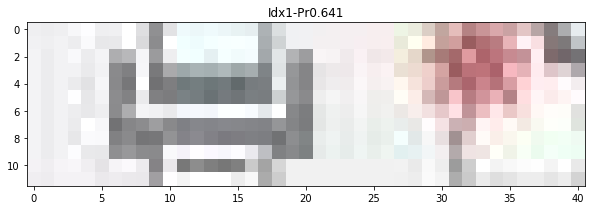

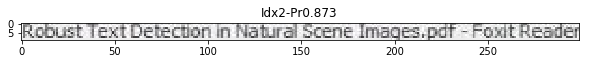

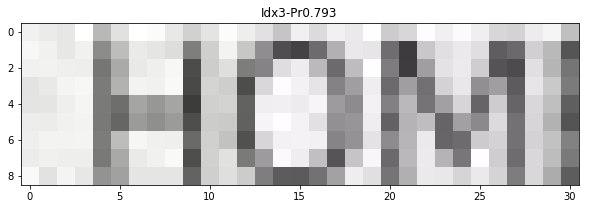

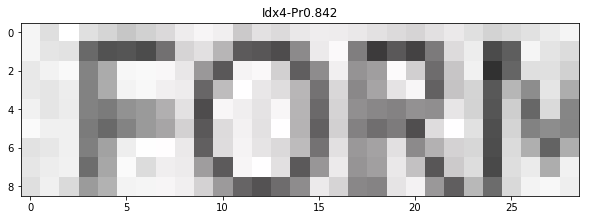

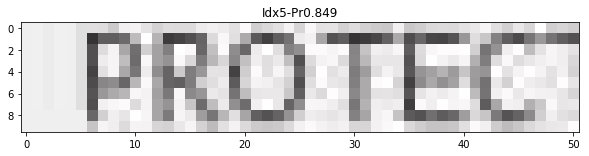

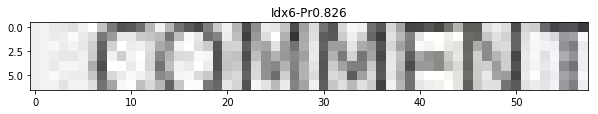

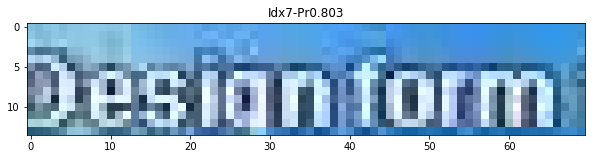

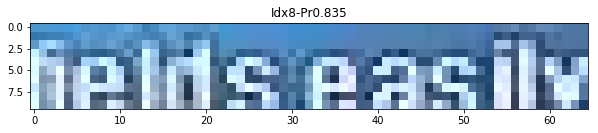

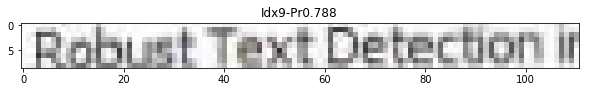

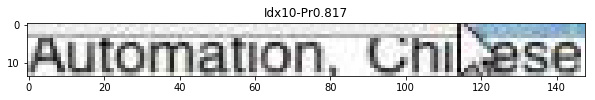

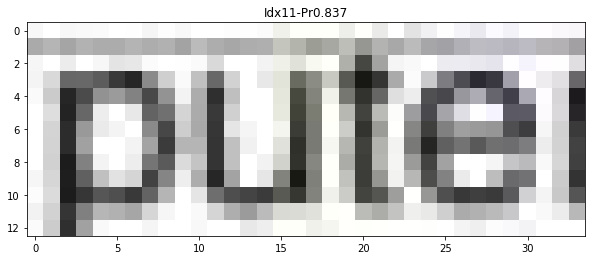

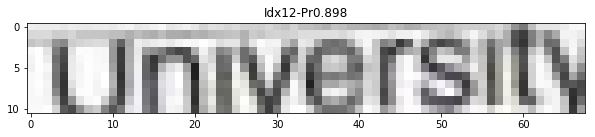

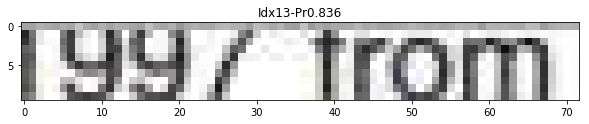

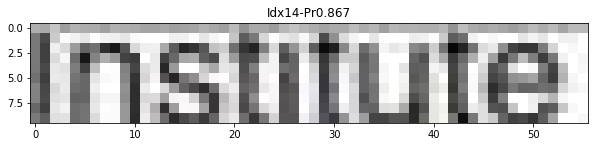

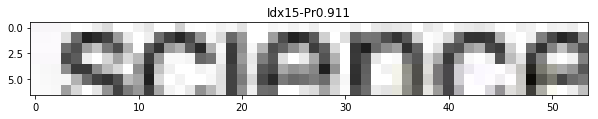

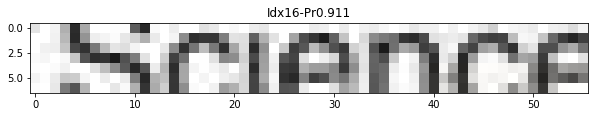

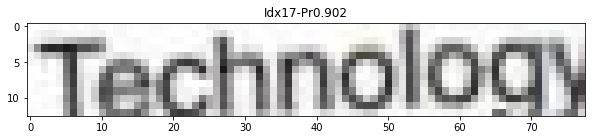

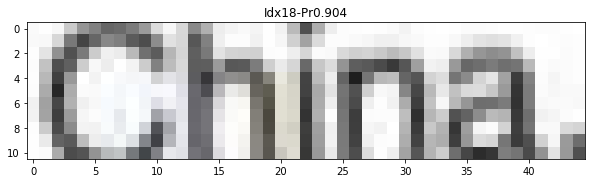

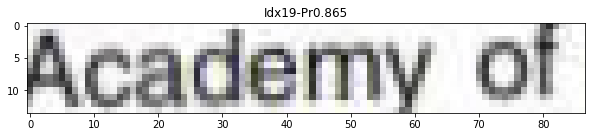

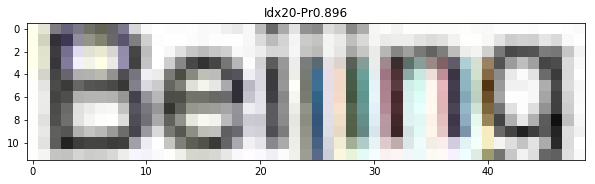

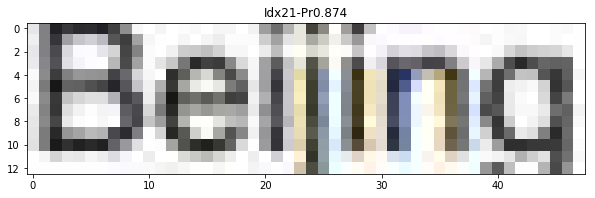

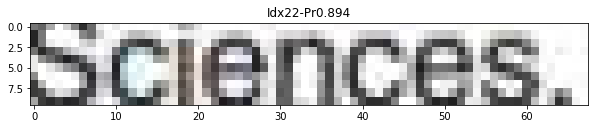

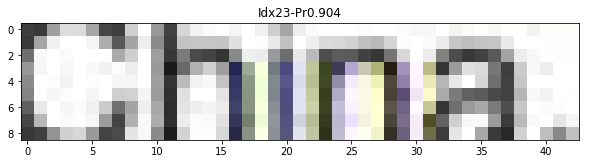

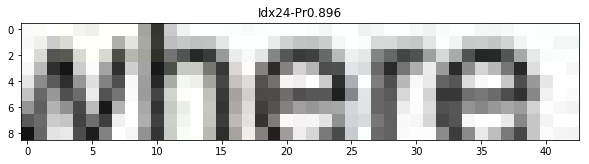

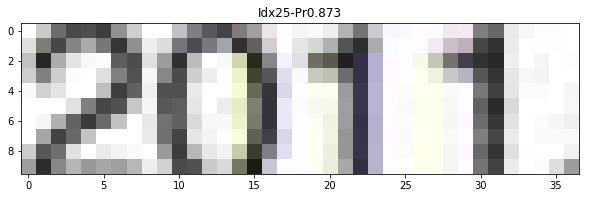

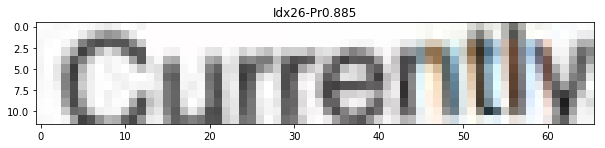

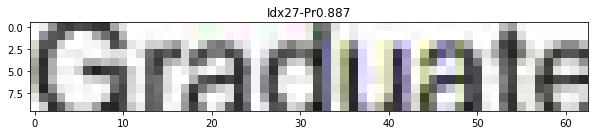

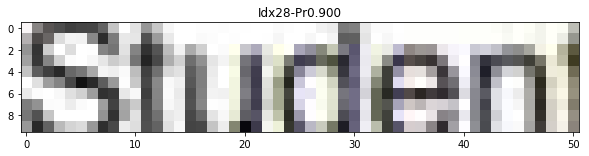

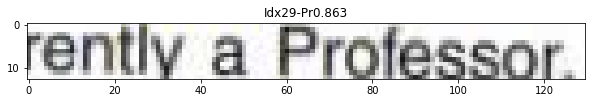

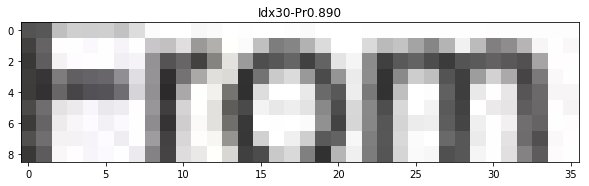

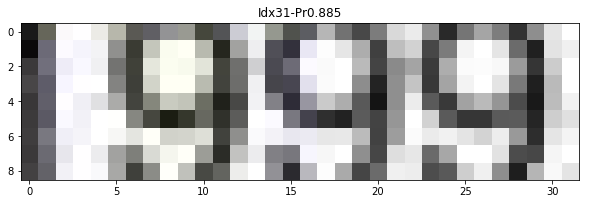

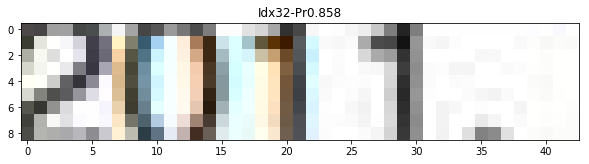

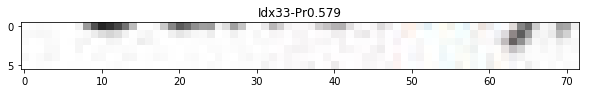

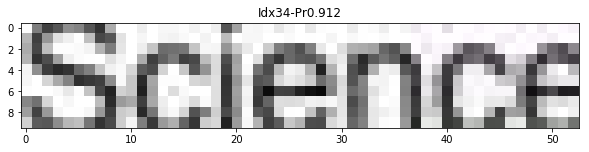

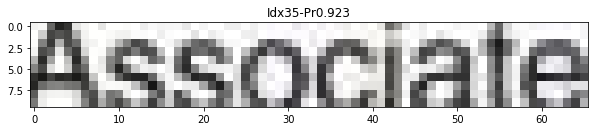

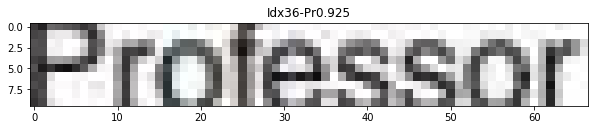

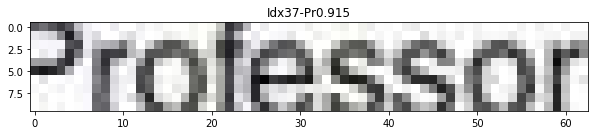

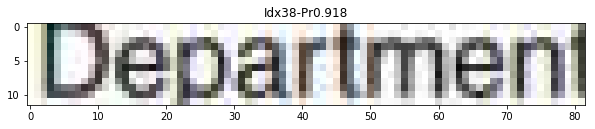

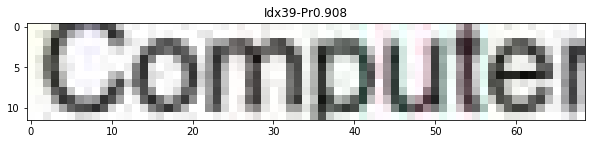

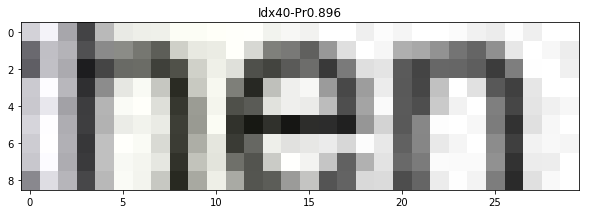

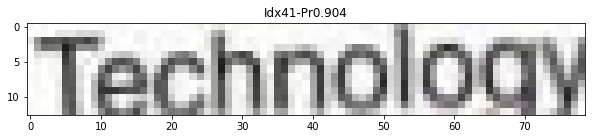

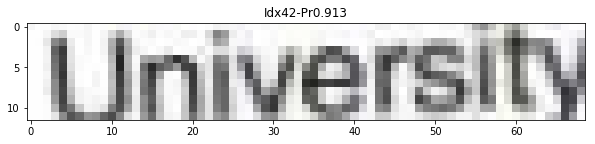

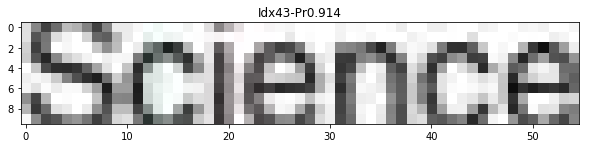

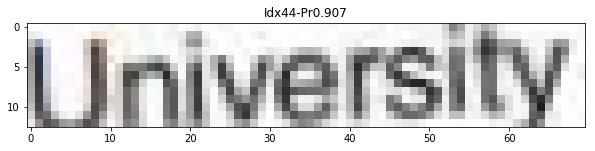

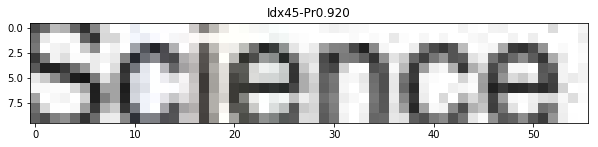

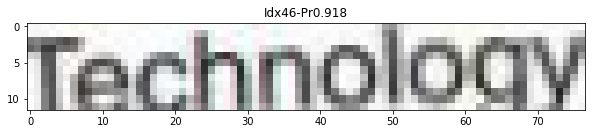

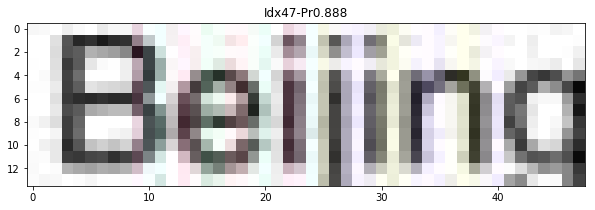

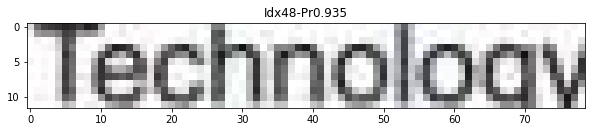

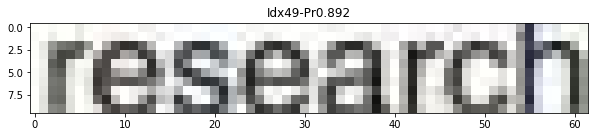

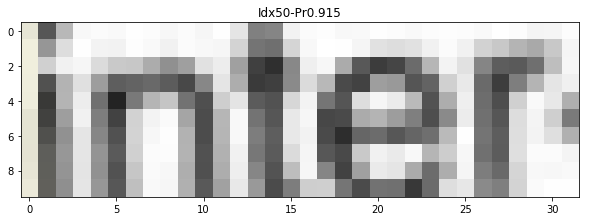

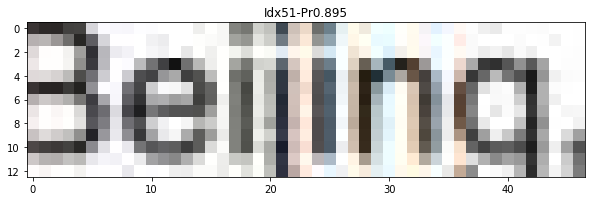

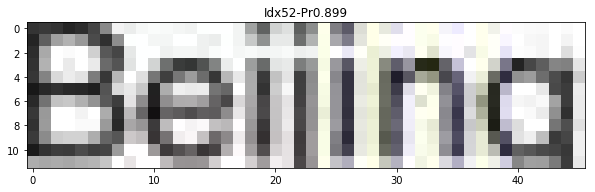

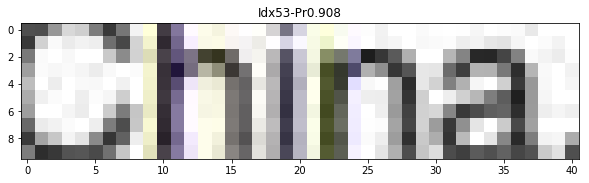

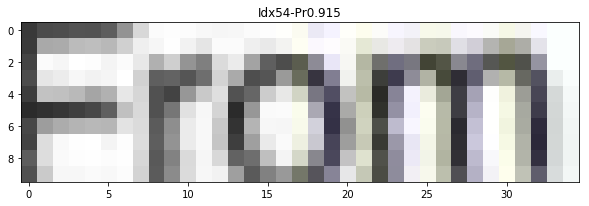

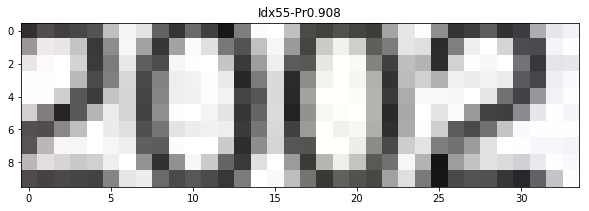

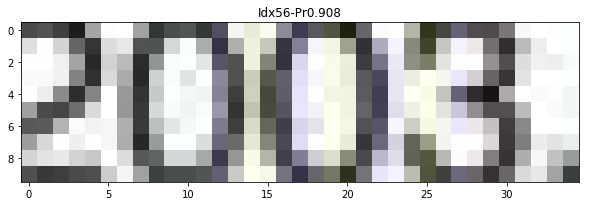

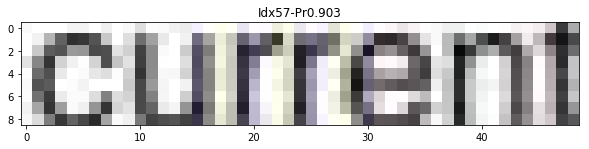

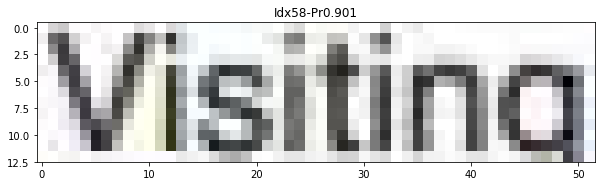

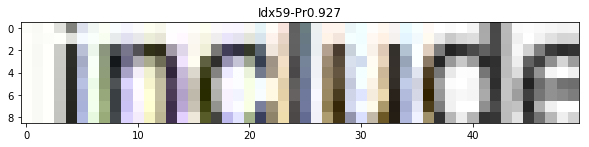

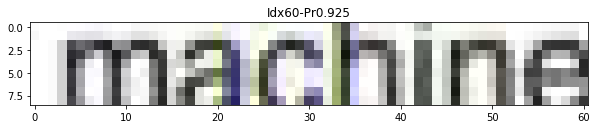

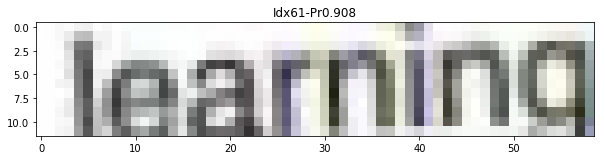

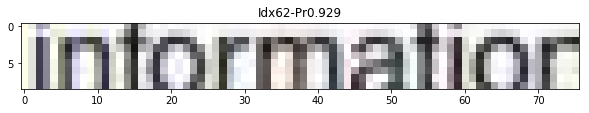

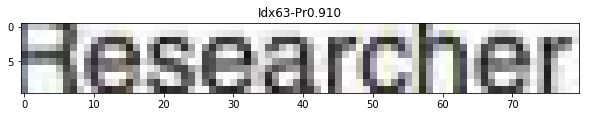

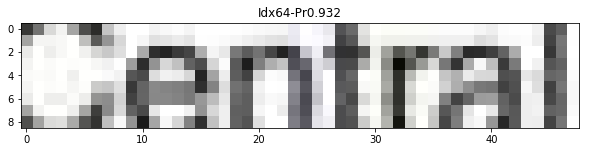

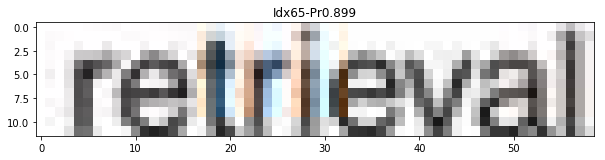

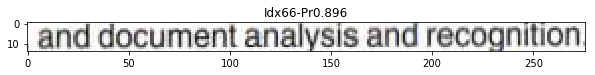

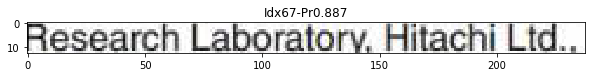

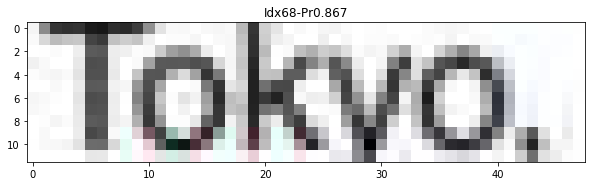

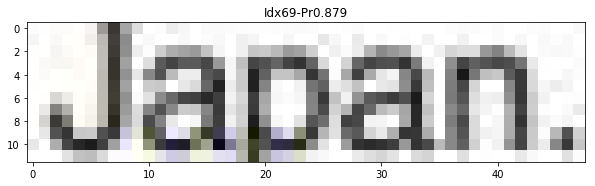

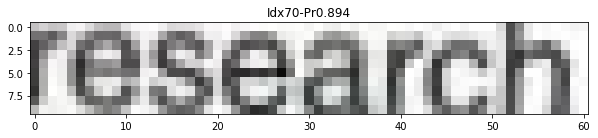

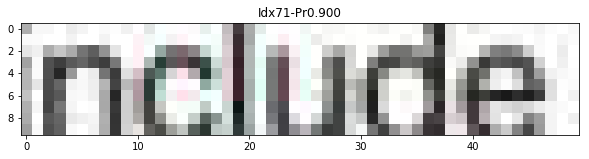

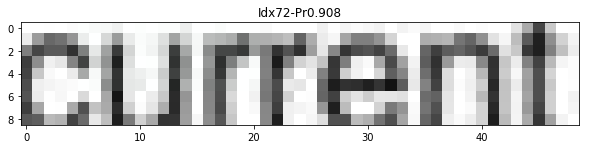

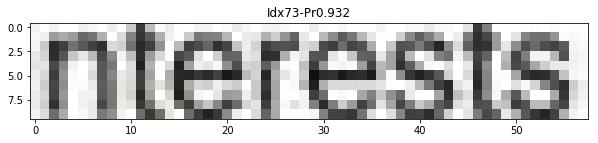

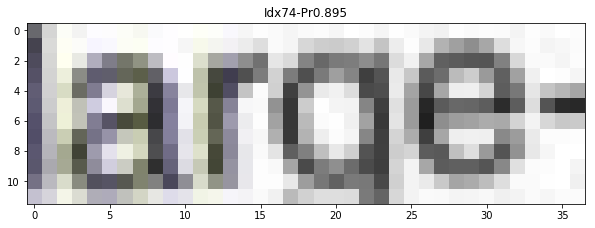

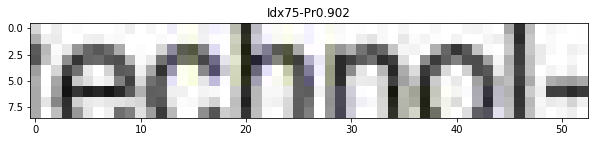

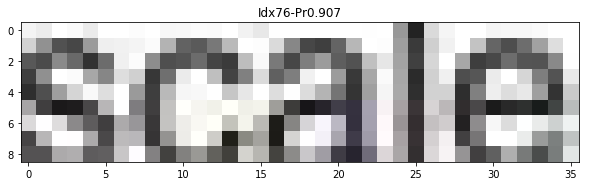

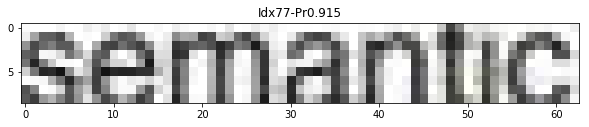

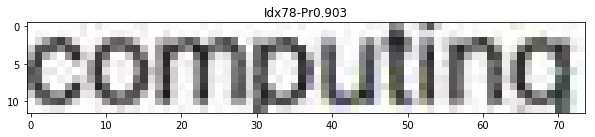

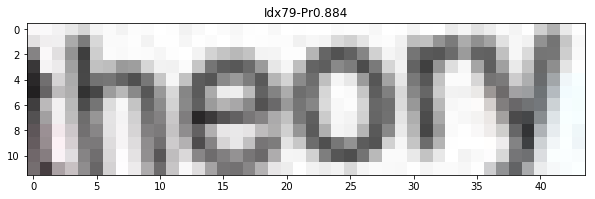

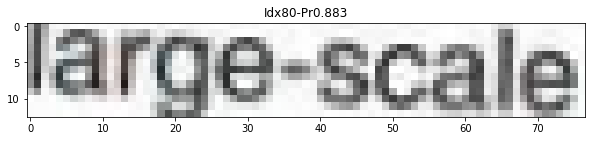

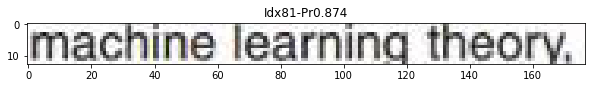

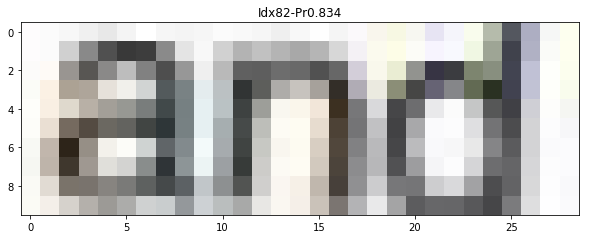

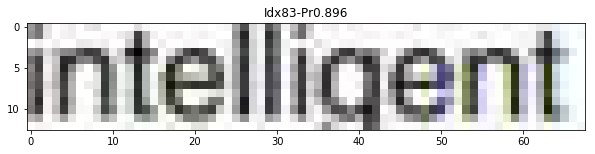

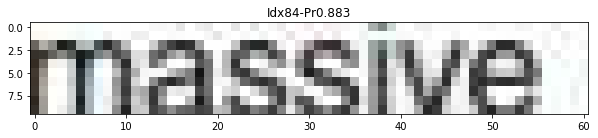

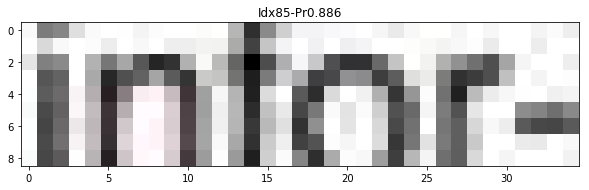

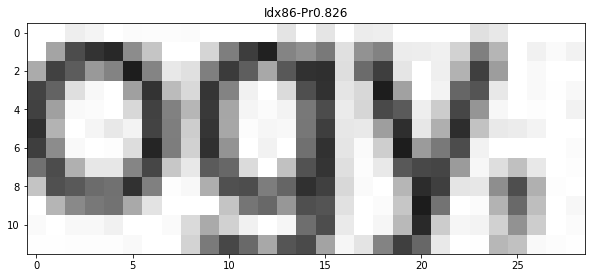

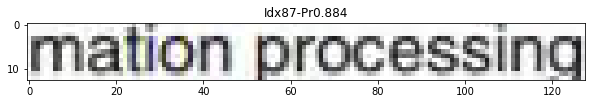

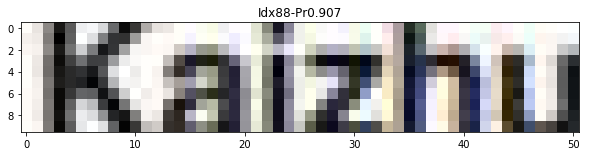

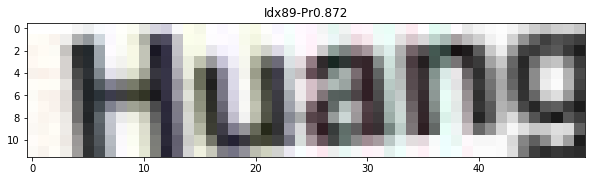

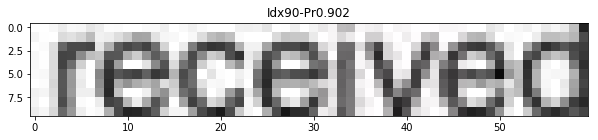

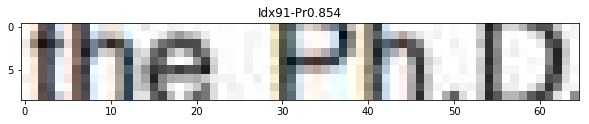

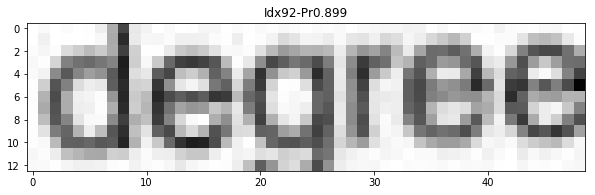

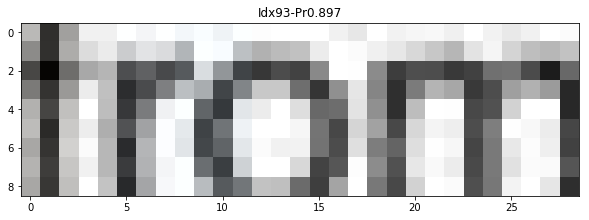

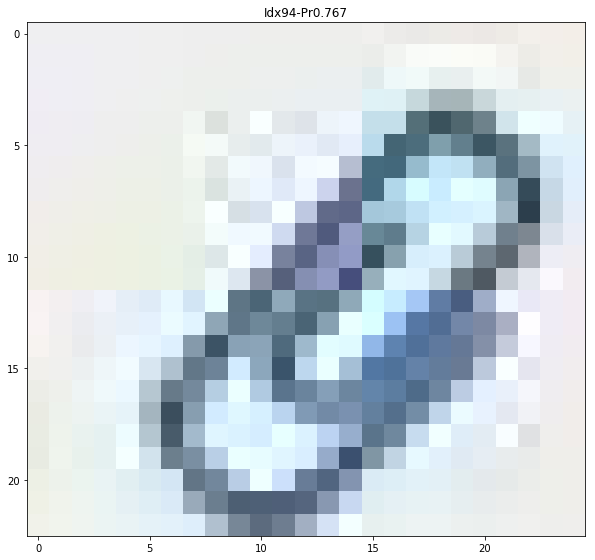

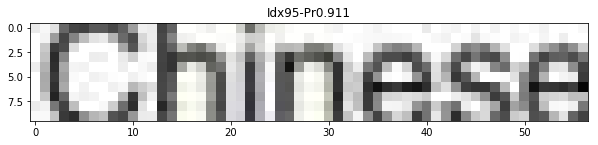

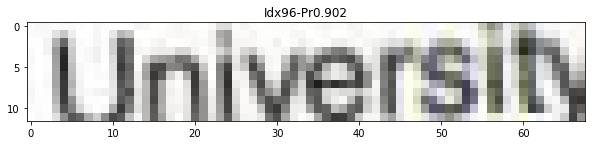

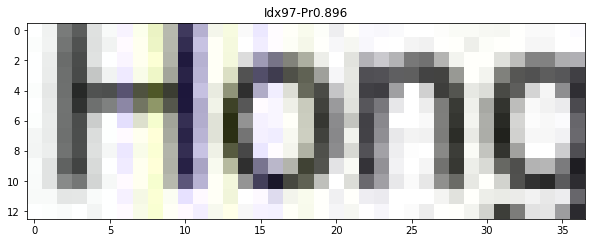

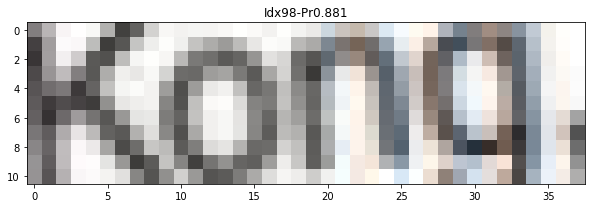

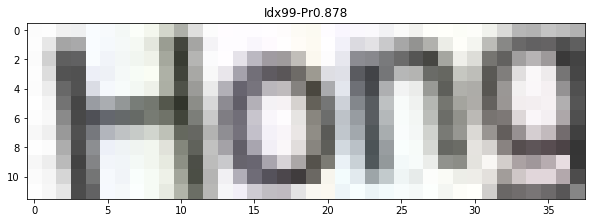

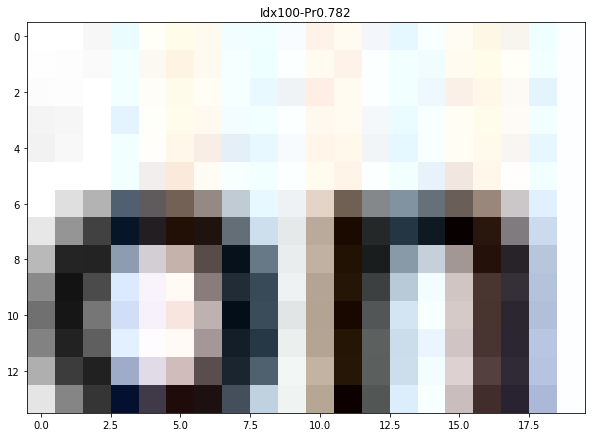

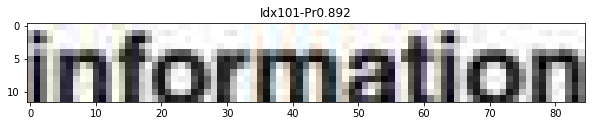

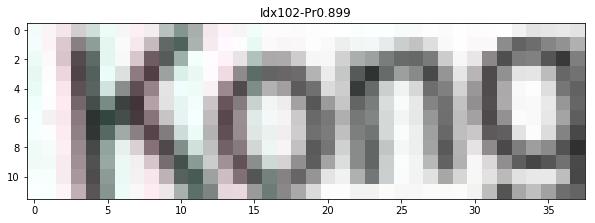

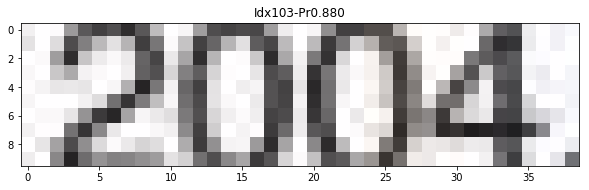

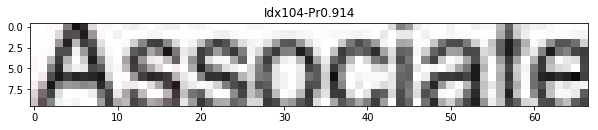

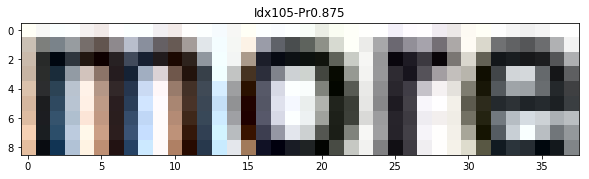

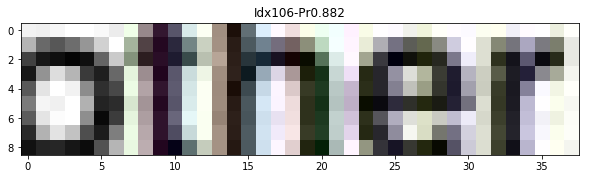

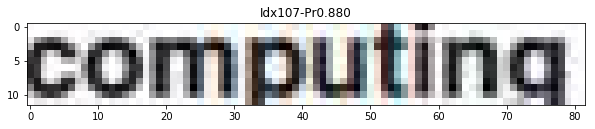

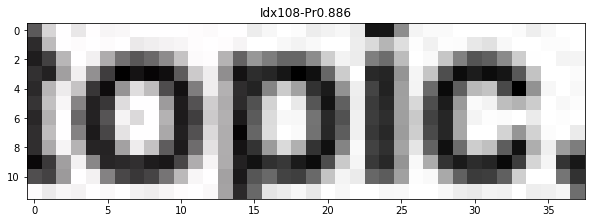

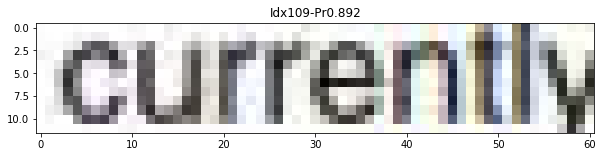

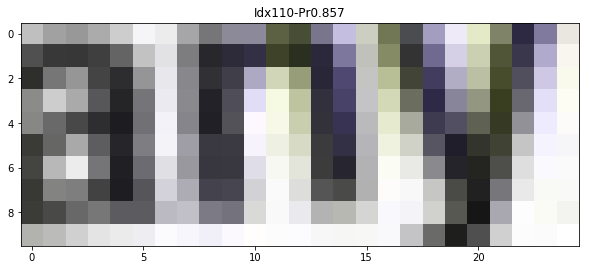

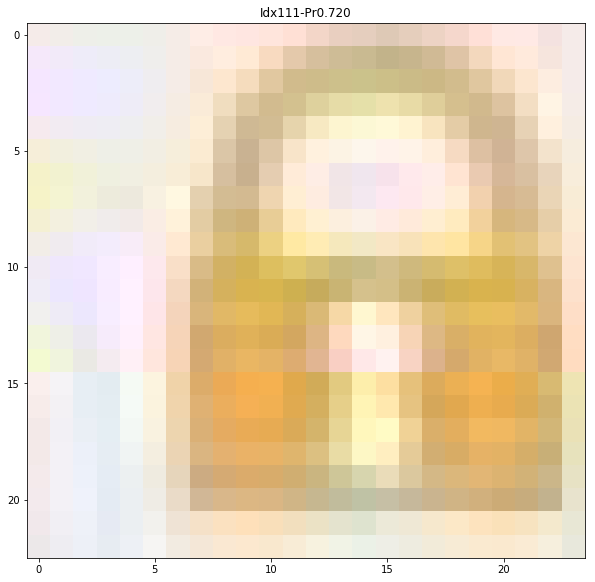

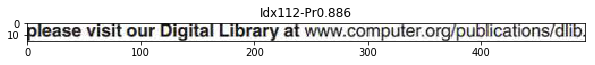

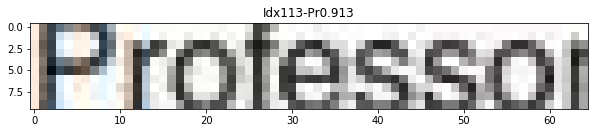

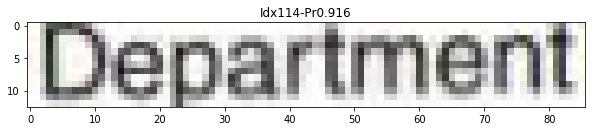

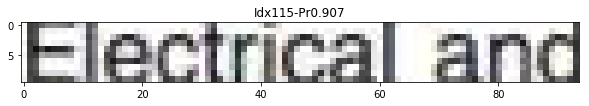

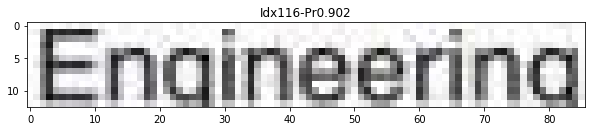

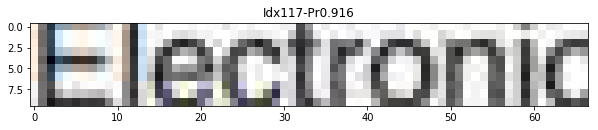

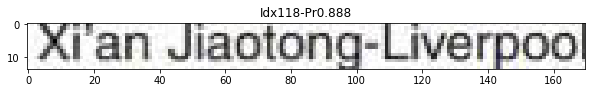

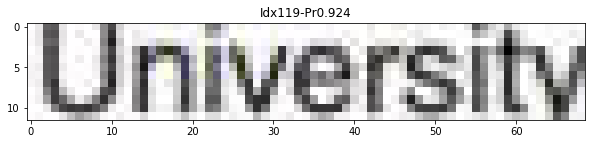

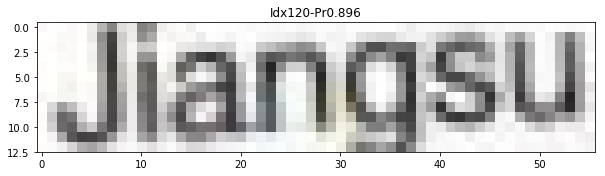

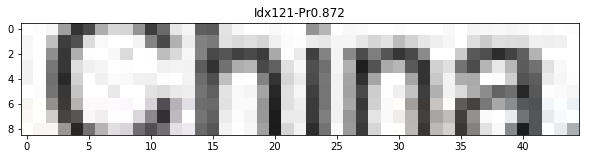

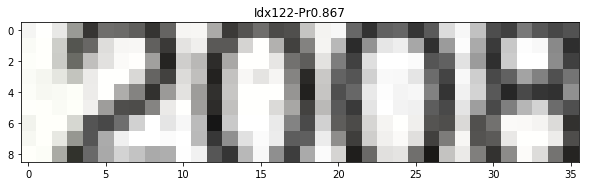

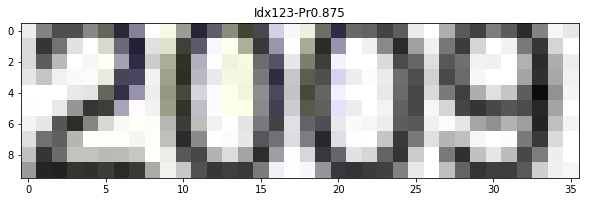

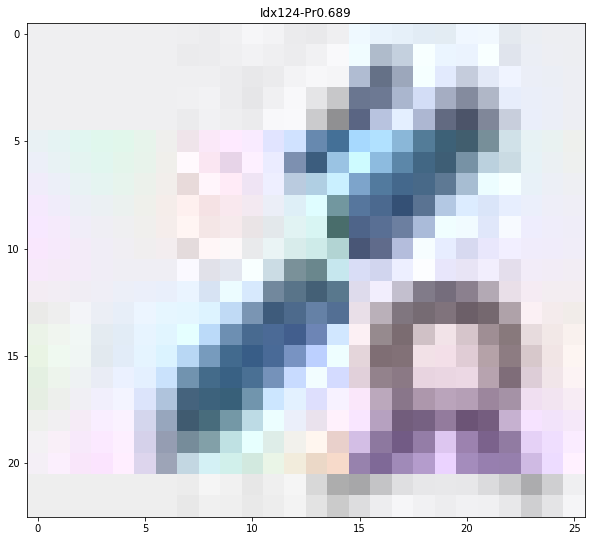

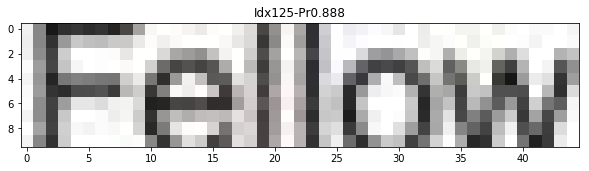

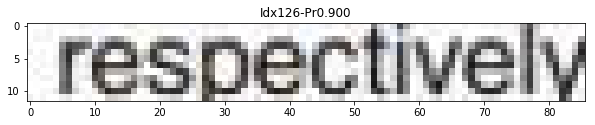

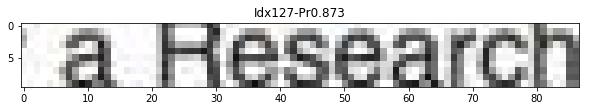

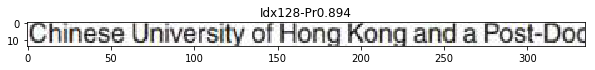

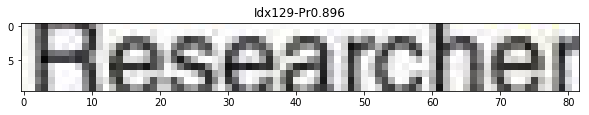

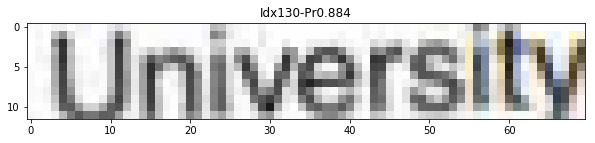

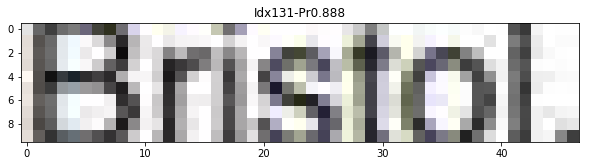

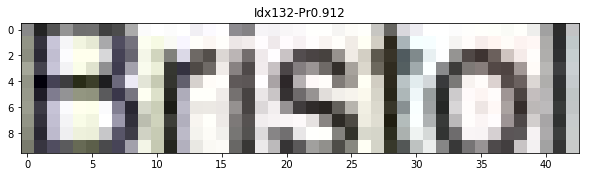

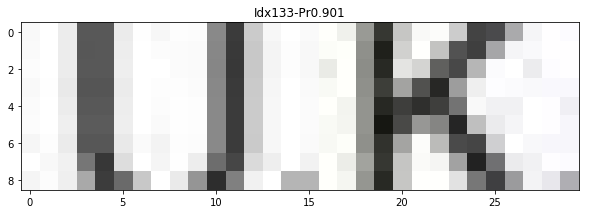

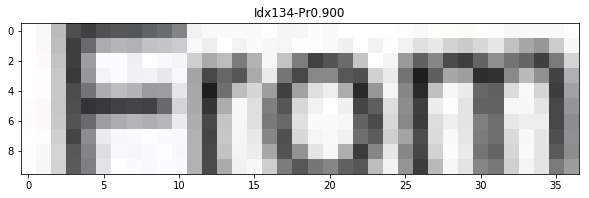

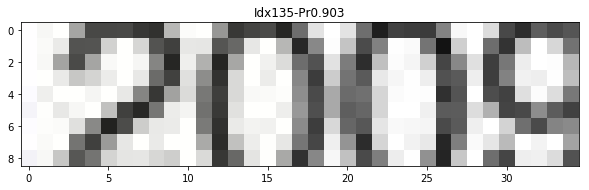

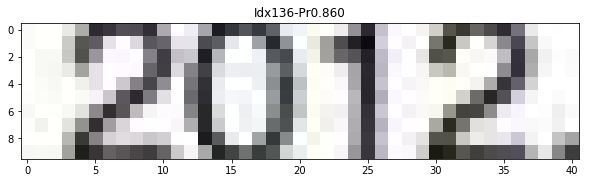

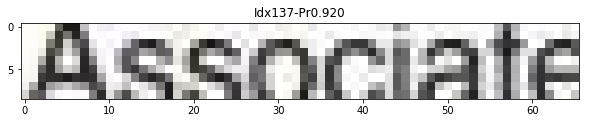

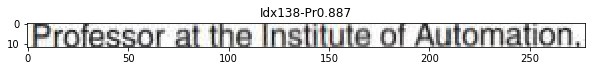

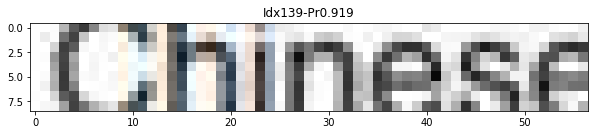

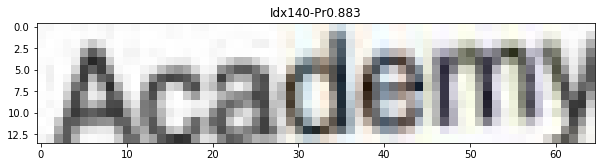

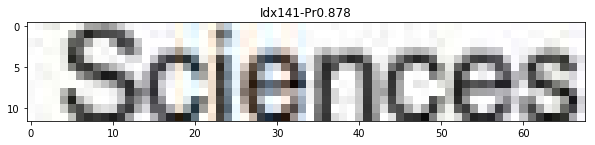

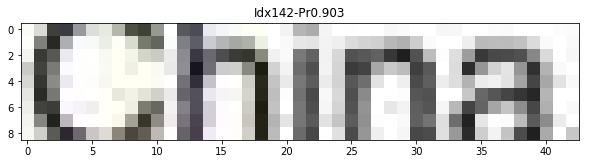

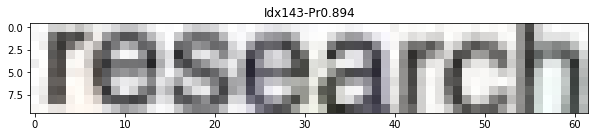

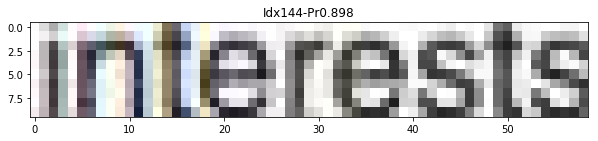

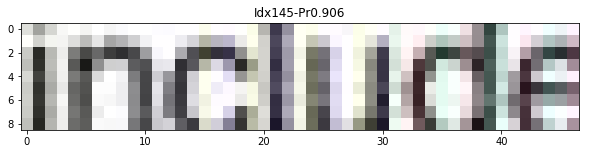

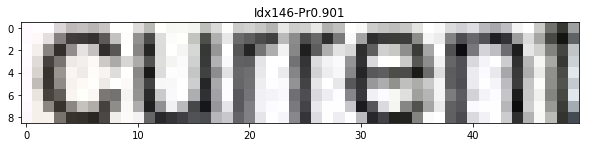

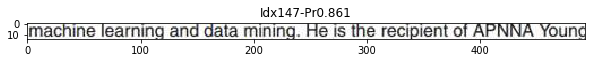

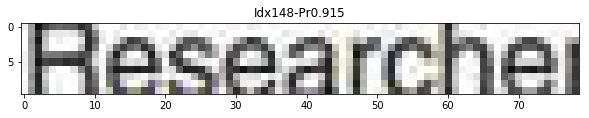

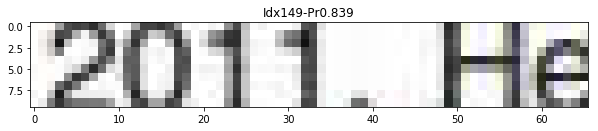

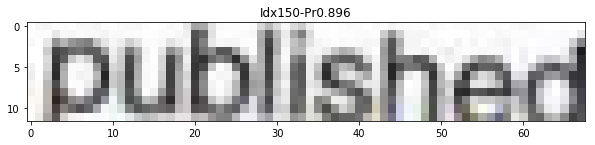

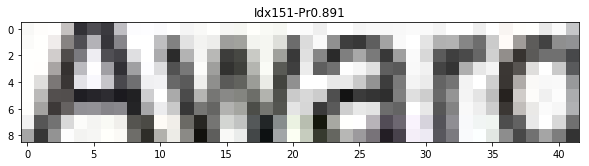

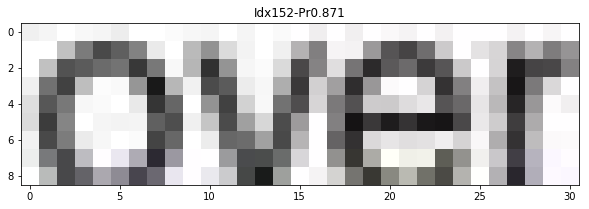

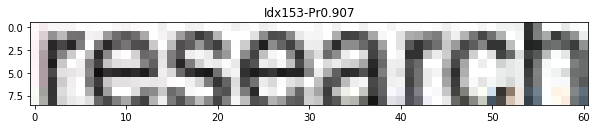

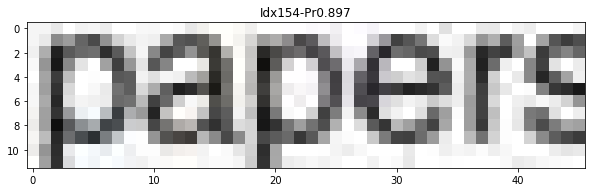

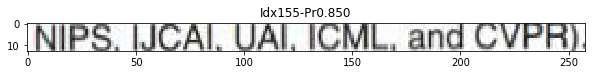

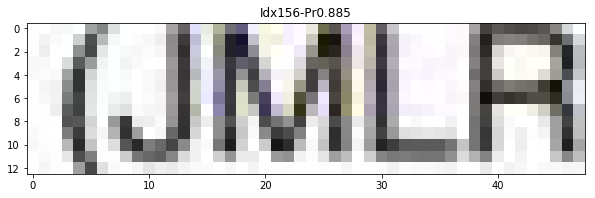

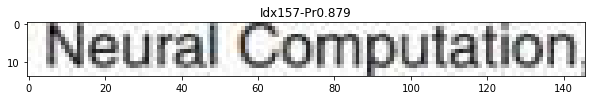

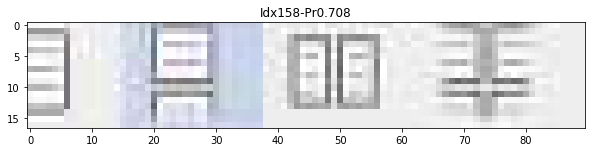

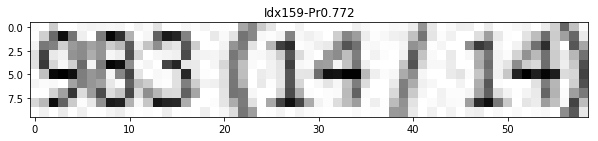

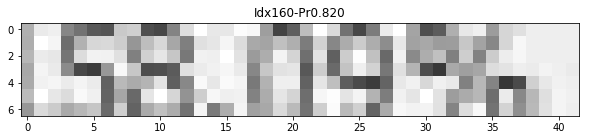

In [16]:
visualize_individual_regions( dec_results, 0, 0  )

## Sample Decoder

Both TextDet and ScriptID models provide raw results, it, therefore, requires necessary post-processing to convert these raw outputs to a desired format. Below we provide a simple decoder supporting the features:

1. read image from a file path or a web-link
2. resize an image
3. thresholds to reject low confident text regions in terms of
    - text region size
    - text probability
4. locate each indiviudal text region and rectify it
5. identify the dominant script ID for an image or each individual text region
6. visualize text probability map and all rectified regions

Feel free to add new features to this simple decoder, e.g. 
- dump rectified region image to disk
- save detection info, including region bounding box, text probability, scriptID probability, etc.

**NOTE**: The provided decoder is a very basic one, and it can be improved at least in the following aspects:
1. self adaptive resize factor: Our training data is dominant by samples with line height in range (20,30) pixel. It is possible to make a two-pass decoder, where the 1st pass is to estimate the page line height, and the 2nd pass is to repropress the adjusted input.
2. better text region identification: The simple decoder only uses the simplest connected component analysis on the text-class map (blue pixels in a text detector output). However, the border-class map (green pixels in a text detector output) is also very useful, especially in separating adjacent text regions. 


In [168]:
from hashlib import md5

def set_vals_in_image3d( image3d, new_image3d, mask, channel_idx=None ) :
    if ( new_image3d.ndim == 3 ) :
        ir, ig, ib = [ image3d[...,k] for k in range(3) ]
        nr, ng, nb = [ new_image3d[...,k] for k in range(3) ]
        for old_ch, new_ch in zip( [ir, ig, ib], [nr, ng, nb]) :
            old_ch[mask] = new_ch[mask]
        return np.dstack( [ir, ig, ib])
    else :
        new_ch_list = []
        for k in range(3) :
            old_ch = image3d[...,k] 
            if ( k==channel_idx ) :
                old_ch[mask] = new_image3d[mask]
            new_ch_list.append( old_ch )
        return np.dstacK( new_ch_list )

def script_proba_minmax( script_proba_all ) :
    idx = np.argmin( script_proba_all[:,1], axis = 0 )
    return script_proba_all[idx]

def text_proba_minmax( text_proba_all ) :
    text_proba_max = np.argmax( text_proba_all[...,-1], axis = 0 )
    print text_proba_max.shape
    proba_max = np.max( text_proba_all, axis = 0 )
    proba_min = np.min( text_proba_all, axis = 0 )
    valid = (proba_max[...,2]>proba_max[...,1]*1.1 ).astype('int32')
    text = proba_max[...,2] * valid + proba_min[...,2] * (1-valid)
    nontext = proba_min[...,0]
    border = 1 - nontext - text
    text_proba = np.dstack([nontext, border, text])
    membership = text_proba.argmax( axis = -1 )
    regions = bwlabel( membership == 2, neighbors=8 )
    num_regs = np.max( regions )
    new_text_proba = np.array( text_proba )
    for reg_idx in range(1,num_regs+1 ):
        mask = regions == reg_idx
        res_indices = np.unique( text_proba_max[mask] )
        res_contrast_list = []
        for res_idx in res_indices :
            this_text = text_proba_all[res_idx][...,2]
            this_border = text_proba_all[res_idx][...,1]
            res_contrast = np.mean(this_text[mask]/(1e-3+this_border[mask]) )
            res_contrast_list.append( res_contrast )
        best_res_idx = res_indices[np.argmax( res_contrast_list )]
        new_text_proba = set_vals_in_image3d( new_text_proba, text_proba_all[best_res_idx], mask )
    return new_text_proba

def lazy_decoder( file_path, 
                  textDet_model,
                  scriptID_model,
                  output_dir='./',
                  min_dec_side=256,
                  max_dec_side=3520,
                  num_resolutions=20,
                  proba_threshold=.55,
                  area_threshold=256,
                  contrast_threshold=24,           
                  ) :
    # 1. read image
    img = read_image( file_path )
    # 1.b resize image if necessary
    ih, iw = img.shape[:2]
    text_proba_list, script_proba_list = [], []
    resize_factor_list = np.linspace( float(min_dec_side)/max(ih,iw), min(6,float(max_dec_side)/max(ih,iw)), num_resolutions )
    if ( np.min( np.abs( resize_factor_list - 1 ) > .05 ) ) :
        resize_factor_list = resize_factor_list.tolist() + [1]
    else :
        resize_factor_list = resize_factor_list.tolist()
    for resize_factor in resize_factor_list :
        if ( np.abs( resize_factor-1 ) < 2e-2 ):
            rimg = img
        elif ( resize_factor > 1 ) :
            # enlarge input
            nh, nw = int(ih*resize_factor), int(iw*resize_factor)
            rimg = cv2.resize( img, (nw, nh), interpolation=cv2.INTER_CUBIC )
        else :
            # shrink input
            nh, nw = int(ih*resize_factor), int(iw*resize_factor)
            rimg = cv2.resize( img, (nw, nh), interpolation=cv2.INTER_AREA )
        # 2. convert input image to network tensor
        rh, rw = rimg.shape[:2]
        print "now using rescale factor =", resize_factor, rh, rw
        if ( max(rh, rw) > 4096 ) :
            break
        elif ( max(rh, rw) < 64 ) :
            continue
        else :
            pass
        x = convert_imageArray_to_inputTensor( rimg )
        # 3. predict text probability map
        text_proba  = textDet_model.predict(x)
        text_proba = text_proba[0,:rh,:rw] # since we always take one sample at a time
        # 3.b resize back to original size
        if ( np.abs( resize_factor-1 ) < 1e-2 ):
            pass
        elif ( resize_factor > 1 ) :
            # shrink proba
            text_proba = cv2.resize( text_proba, (iw, ih), interpolation=cv2.INTER_AREA )
        else :
            # enlarge proba
            text_proba = cv2.resize( text_proba, (iw, ih), interpolation=cv2.INTER_CUBIC )
        # 4. predict script ID
        script_proba = scriptID_model.predict(x[:,::2,::2])
        # 5. update
        text_proba_list.append( np.expand_dims( text_proba, axis=0 ) )
        script_proba_list.append( script_proba )
    text_proba_all = np.concatenate( text_proba_list, axis=0 )
    script_proba_all = np.row_stack( script_proba_list )
    # 6. minimax decode
    text_proba = text_proba_minmax( text_proba_all )
    script_proba = script_proba_minmax( script_proba_all )
    scriptID = decode_scriptID( script_proba )
    print script_proba, scriptID
    # 6.b sample connected component analysis based decoder
    membership = text_proba.argmax( axis = -1 )
    regions = bwlabel( membership == 2, neighbors=8 )
    if (img.ndim==2) :
        img = np.dstack([img for k in range(3)])
    decoded_results = decode_text_bboxes( img, text_proba[...,-1], regions )
    # 6. save detection results 
    # modify this section to save additional/different information
    header = ','.join(['rectX', 'rectY', 'proba', 'file'] )
    det_results = [ header ]
    valid_indices = []
    prefix = '{}'.format( md5( img ).hexdigest() )
    for idx, (bbox, proba, wrapped_image) in enumerate( decoded_results ):
        if ( proba < proba_threshold ) :
            continue
        upper_left, upper_right, lower_right, lower_left = bbox
        cnt = np.row_stack([upper_left, upper_right, lower_right, lower_left]) 
        area = cv2.contourArea( cnt )
        if ( area < area_threshold ) :
            continue
        contrast = np.max( wrapped_image.std(axis=(0,1)) )
        if ( contrast < contrast_threshold ) :
            continue
        cnt_x = ";".join([ '{:d}'.format( pt[0] ) for pt in np.round( cnt ).astype('int32') ])
        cnt_y = ";".join([ '{:d}'.format( pt[1] ) for pt in np.round( cnt ).astype('int32') ])
        output_file = os.path.join( output_dir, prefix + '-{:3d}.png'.format(idx) )
        cv2.imwrite( output_file, wrapped_image[...,::-1] )
        this_line = [ cnt_x, cnt_y, '{:.3f}'.format(proba), output_file ]
        this_line = ','.join( this_line )
        det_results.append( this_line )
        valid_indices.append(idx)
    det_results = '\n'.join( det_results )
    valid_results = [decoded_results[k] for k in valid_indices]
    return det_results, valid_results

In [410]:
def text_proba_minmax( text_proba_all ) :
    proba_max = np.max( text_proba_all, axis = 0 )
    proba_min = np.min( text_proba_all, axis = 0 )
    valid = (proba_max[...,2]>proba_max[...,1]*1.1 ).astype('int32')
    text = proba_max[...,2] * valid + proba_min[...,2] * (1-valid)
    nontext = proba_min[...,0]
    border = 1 - nontext - text
    return np.dstack( [ nontext, border, text ] )


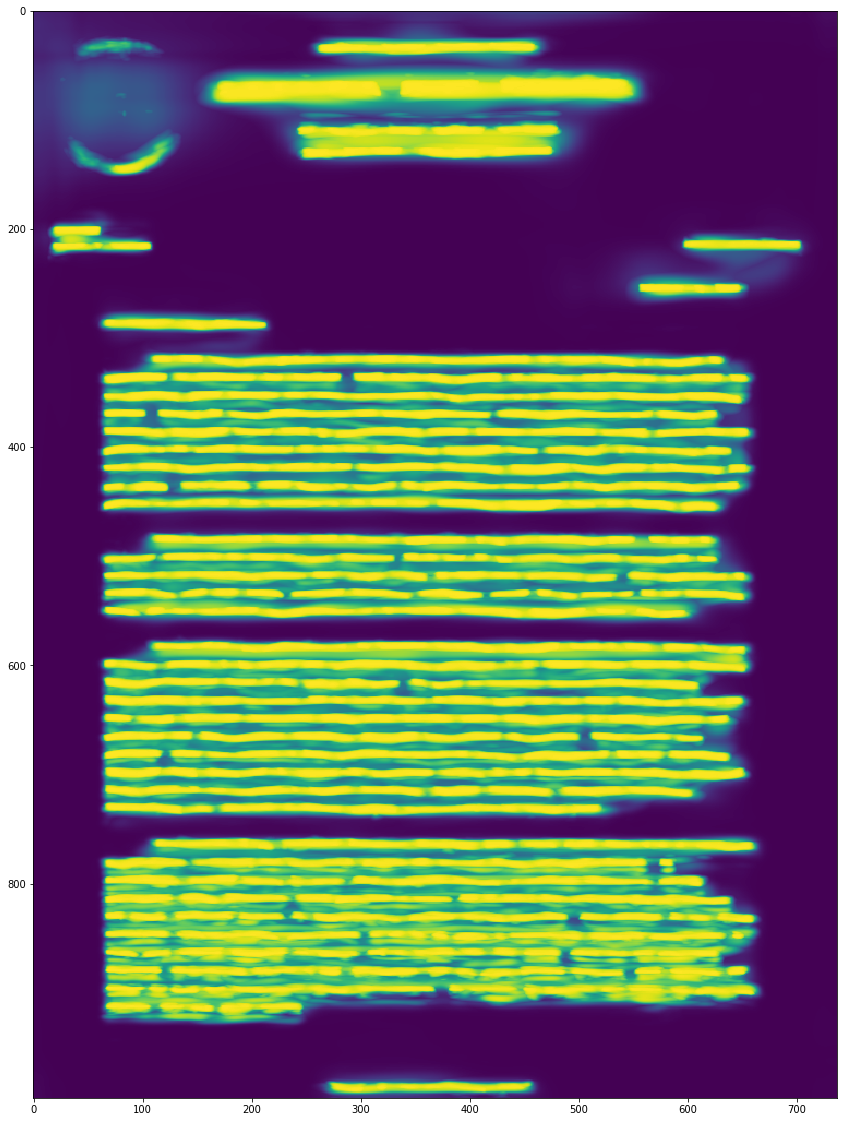

In [384]:
pyplot.figure(figsize=(20,20))
pyplot.imshow( y.reshape([nb_rows, nb_cols]) )

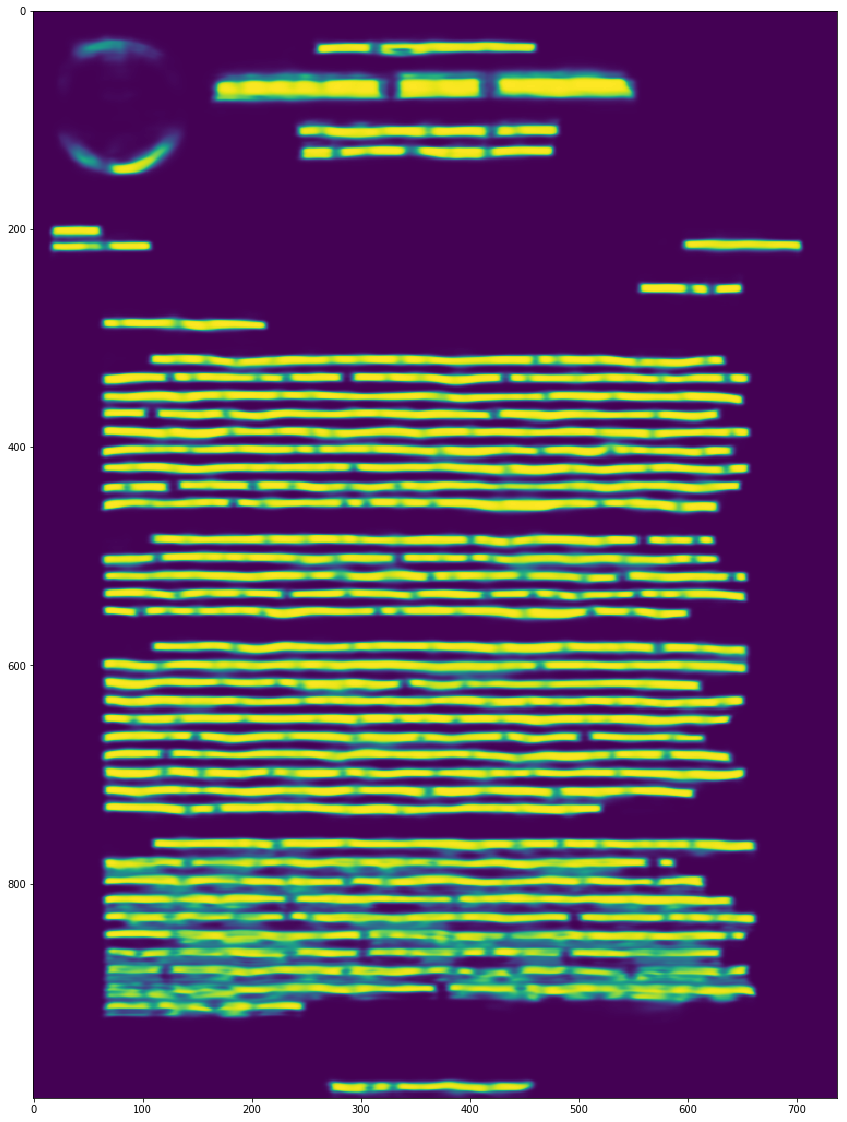

In [406]:
pyplot.figure(figsize=(20,20))
pyplot.imshow( model.predict(feat).reshape([2, nb_rows, nb_cols])[0] )

In [411]:
def text_proba_minmax( text_proba_all ) :
    text_proba_max = np.argmax( text_proba_all[...,-1], axis = 0 )
    print text_proba_max.shape
    proba_max = np.max( text_proba_all, axis = 0 )
    proba_min = np.min( text_proba_all, axis = 0 )
    valid = (proba_max[...,2]>proba_max[...,1]*1.1 ).astype('int32')
    text = proba_max[...,2] * valid + proba_min[...,2] * (1-valid)
    nontext = proba_min[...,0]
    border = 1 - nontext - text
    text_proba = np.dstack([nontext, border, text])
    membership = text_proba.argmax( axis = -1 )
    regions = bwlabel( membership == 2, neighbors=8 )
    num_regs = np.max( regions )
    new_text_proba = np.array( text_proba )
    for reg_idx in range(1,num_regs+1 ):
        mask = regions == reg_idx
        res_indices = np.unique( text_proba_max[mask] )
        res_contrast_list = []
        for res_idx in res_indices :
            this_text = text_proba_all[res_idx][...,2]
            this_border = text_proba_all[res_idx][...,1]
            res_contrast = np.mean(this_text[mask]/(1e-3+this_border[mask]) )
            res_contrast_list.append( res_contrast )
        best_res_idx = res_indices[np.argmax( res_contrast_list )]
        new_text_proba = set_vals_in_image3d( new_text_proba, text_proba_all[best_res_idx], mask )
    return new_text_proba

In [294]:
def set_vals_in_image3d( image3d, new_image3d, mask, channel_idx=None ) :
    if ( new_image3d.ndim == 3 ) :
        ir, ig, ib = [ image3d[...,k] for k in range(3) ]
        nr, ng, nb = [ new_image3d[...,k] for k in range(3) ]
        for old_ch, new_ch in zip( [ir, ig, ib], [nr, ng, nb]) :
            old_ch[mask] = new_ch[mask]
        return np.dstack( [ir, ig, ib])
    else :
        new_ch_list = []
        for k in range(3) :
            old_ch = image3d[...,k] 
            if ( k==channel_idx ) :
                old_ch[mask] = new_image3d[mask]
            new_ch_list.append( old_ch )
        return np.dstacK( new_ch_list )
        
            

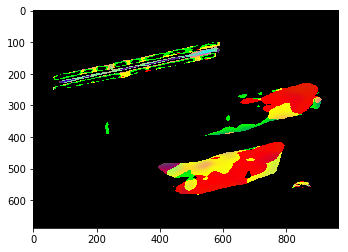

In [302]:
pyplot.imshow( text_proba - new_text_proba )

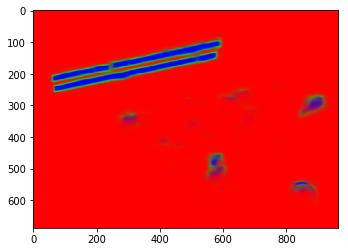

In [290]:
pyplot.imshow( text_proba_all[6])

In [278]:
np.bincount?

In [ ]:
def decode_text_bboxes( image, proba, proba_all, labeled_regions ) :
    nb_regs = np.max( labeled_regions )
    results = []
    for reg_idx in range( 1, nb_regs + 1 ) :
        mask = ( labeled_regions == reg_idx ).astype('uint8')
        try :
            corner_pts, pr, wrapped = decode_one_bbox_mask( mask, image, proba )
        except :
            continue
        results.append( [ corner_pts, pr, wrapped ] )
    return results



In [192]:
bbox, proba, wrapped_image = decoded_results[7]
print proba
upper_left, upper_right, lower_right, lower_left = bbox
area = np.product( lower_right - upper_left )
print area
print upper_left, lower_right
print bbox

0.872151
-803.994
[ 255.307  131.207] [ 422.257  126.391]
[array([ 255.307,  131.207], dtype=float32), array([ 418.985,  105.532], dtype=float32), array([ 422.257,  126.391], dtype=float32), array([ 258.579,  152.066], dtype=float32)]


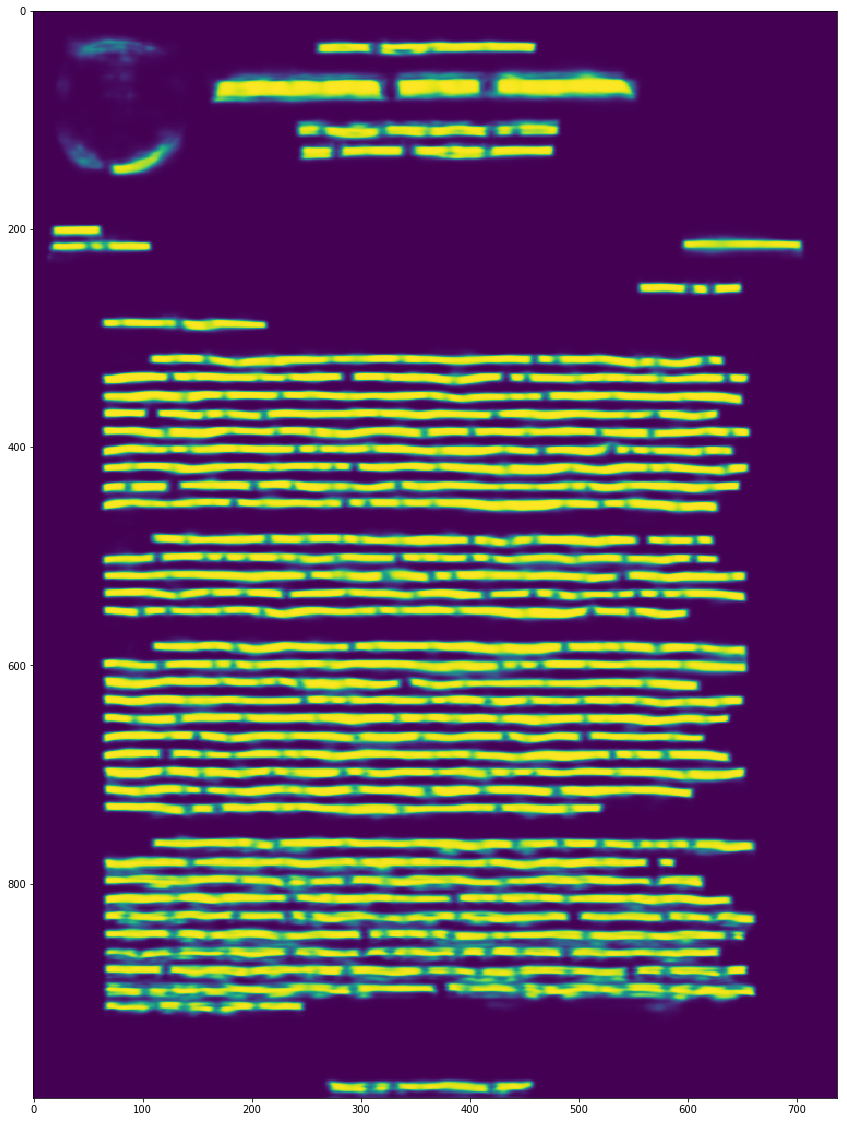

In [365]:
pyplot.figure(figsize=(20,20))
pyplot.imshow( text_proba_all[13][...,-1])

In [194]:
valid_indices

[2, 6, 11, 12, 15, 16, 17, 19, 20, 21, 22]

In [186]:
cnt = np.row_stack([upper_left, upper_right, lower_right, lower_left]) 
cv2.contourArea(cnt)

3498.223884774372

(21, 720, 1280, 3)
(720, 1280)
[ 0.     0.281  0.008  0.006  0.001  0.689  0.014] ['Chinese']
Total = 381
Reject 0 due to small area 0.750755611731 52.0 106.43743811
Reject 1 due to small area 0.693520902087 221.0 106.43743811
Reject 2 due to low contrast 0.783978824609 528.0 16.7326448883
Reject 3 due to small area 0.727098561445 84.0 16.7326448883
Reject 4 due to small area 0.681305225287 216.0 16.7326448883
Reject 5 due to low proba, 0.509006415003 216.0 16.7326448883
Reject 7 due to low proba, 0.415887591385 2700.0 56.6885110208
Reject 8 due to low proba, 0.502401027828 2700.0 56.6885110208
Reject 9 due to small area 0.751298629267 48.0 56.6885110208
Reject 10 due to low proba, 0.479226039068 48.0 56.6885110208
Reject 11 due to low proba, 0.43489074856 48.0 56.6885110208
Reject 12 due to small area 0.717394101575 247.0 56.6885110208
Reject 13 due to small area 0.59161200126 10.0 56.6885110208
Reject 14 due to low proba, 0.504020467401 10.0 56.6885110208
Reject 15 due to small area 

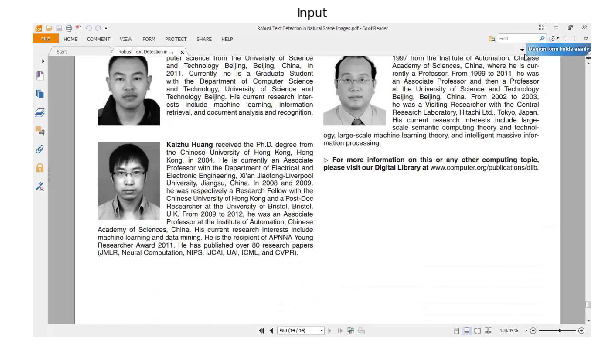

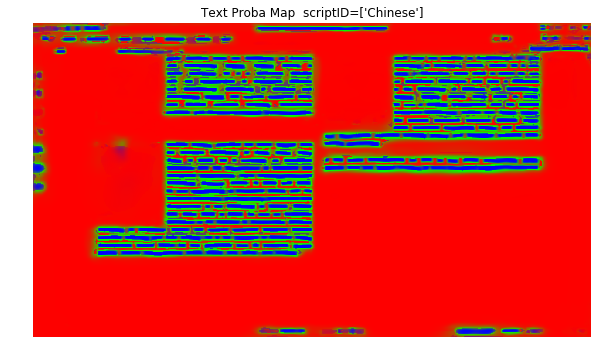

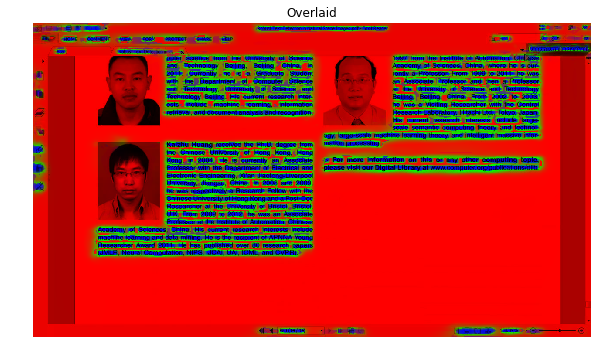

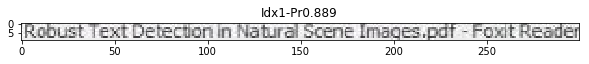

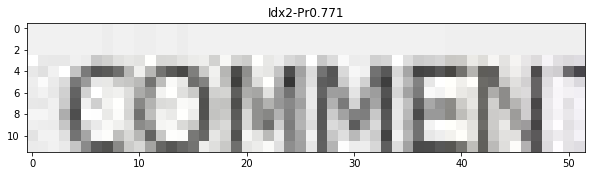

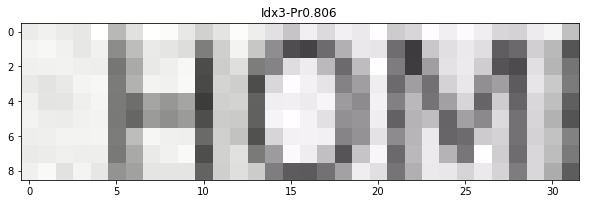

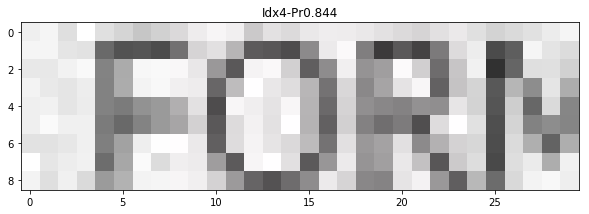

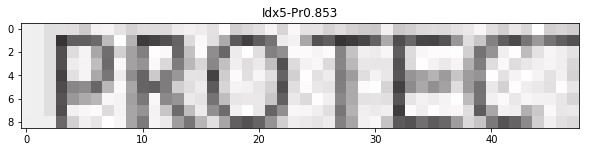

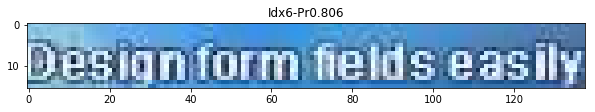

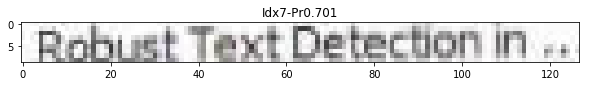

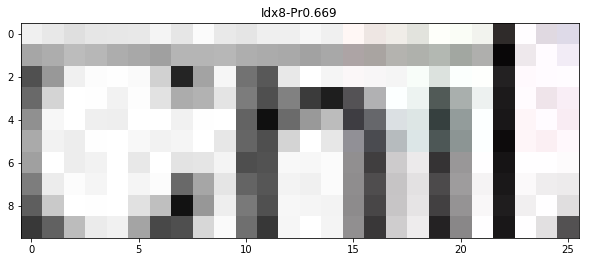

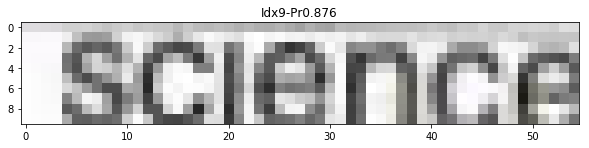

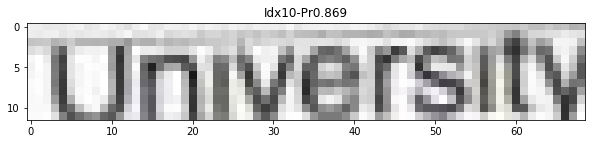

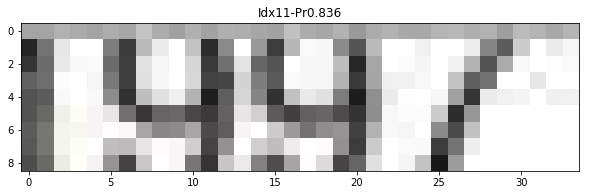

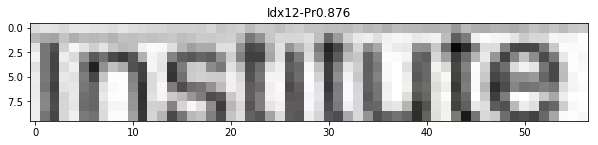

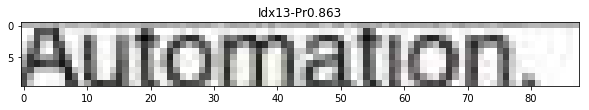

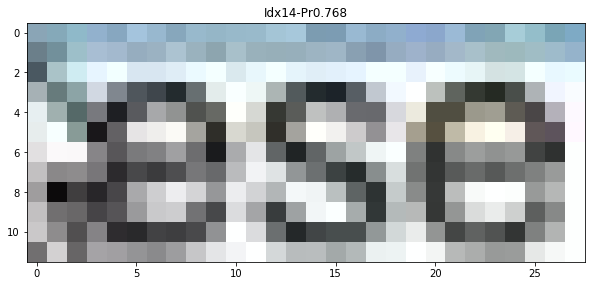

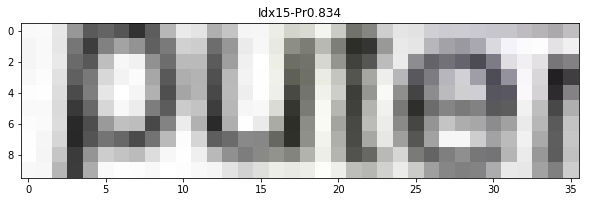

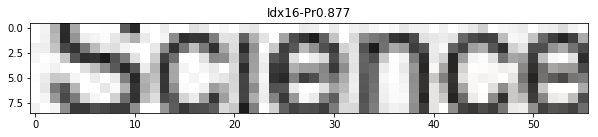

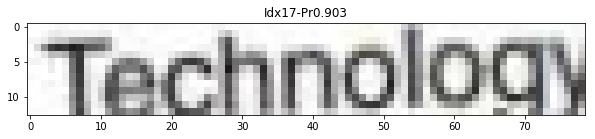

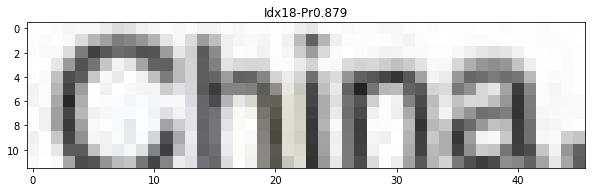

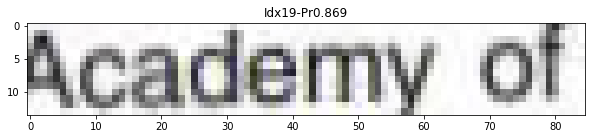

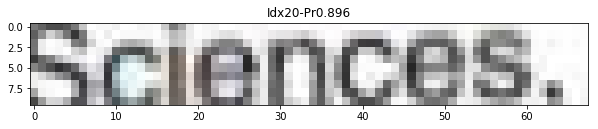

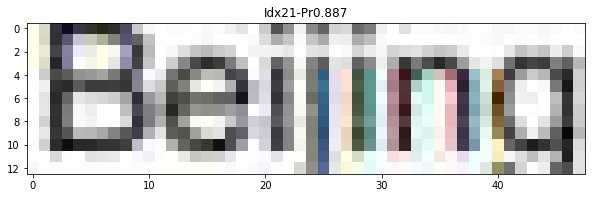

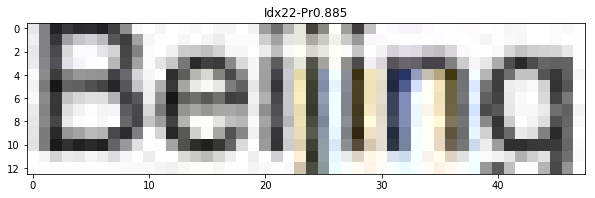

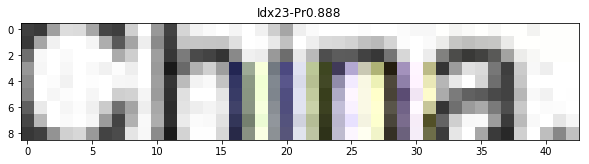

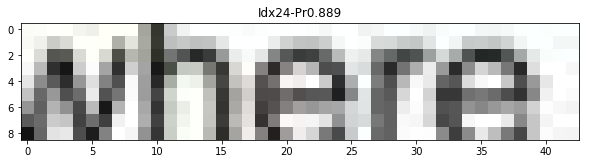

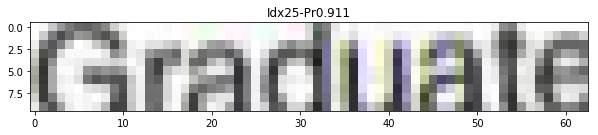

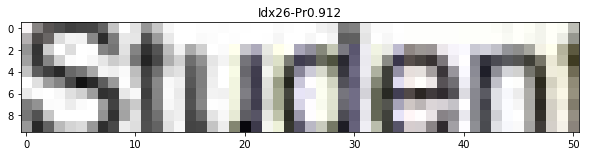

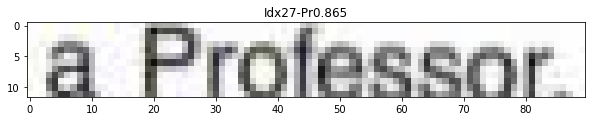

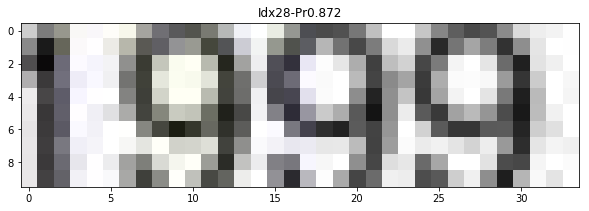

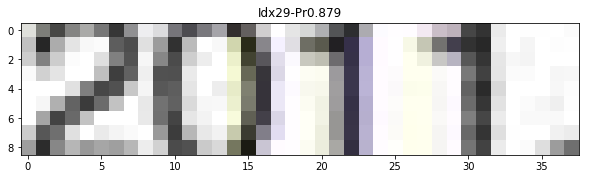

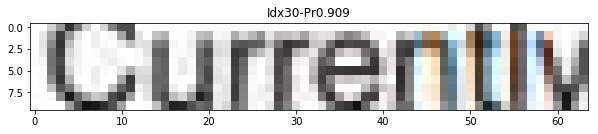

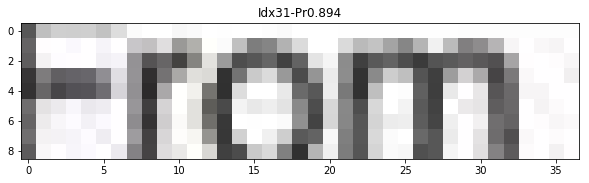

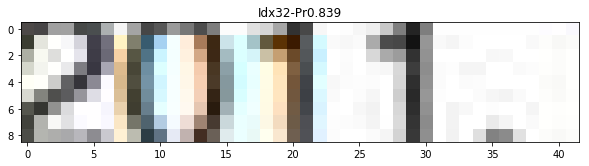

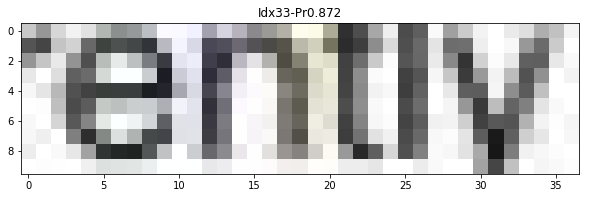

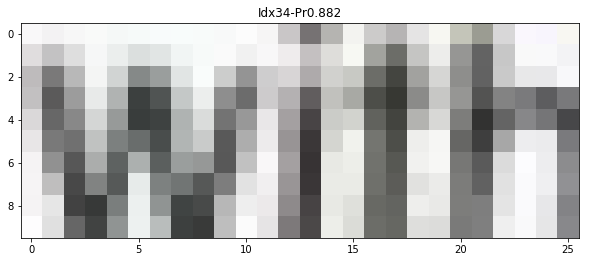

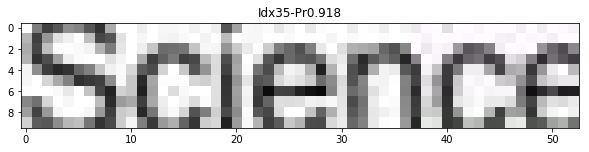

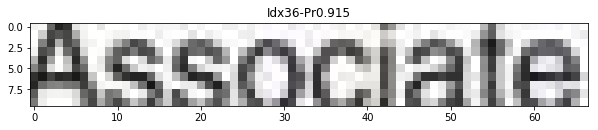

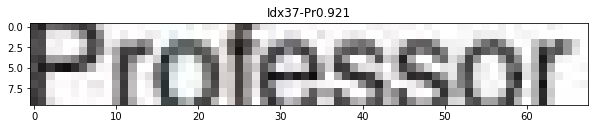

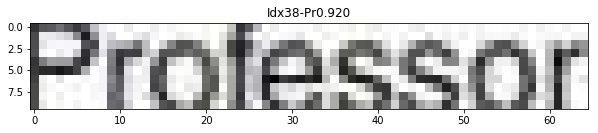

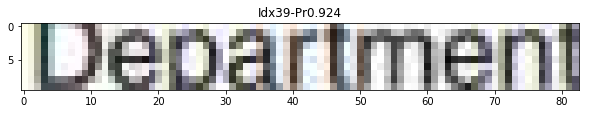

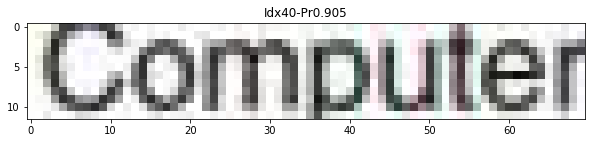

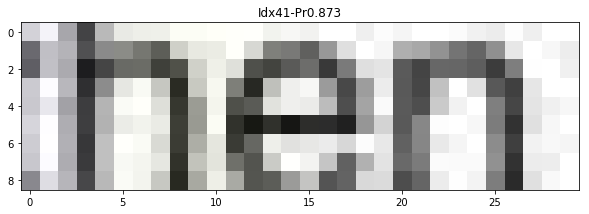

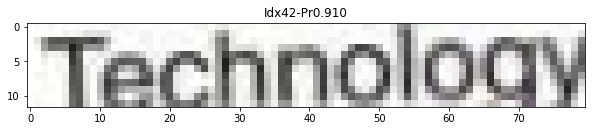

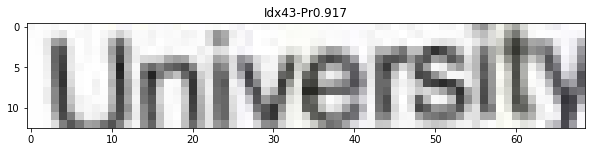

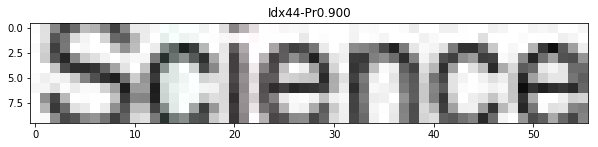

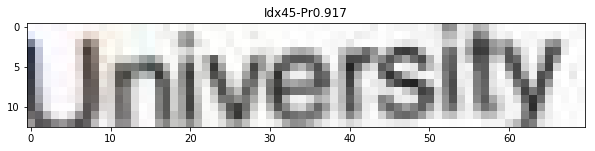

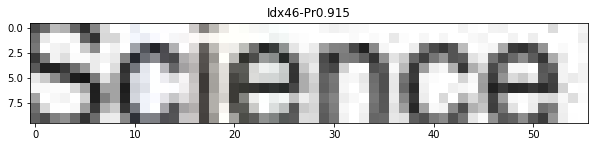

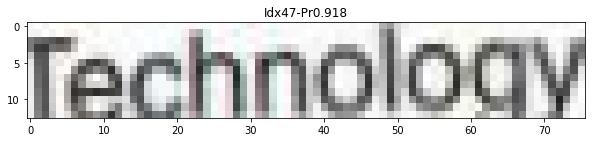

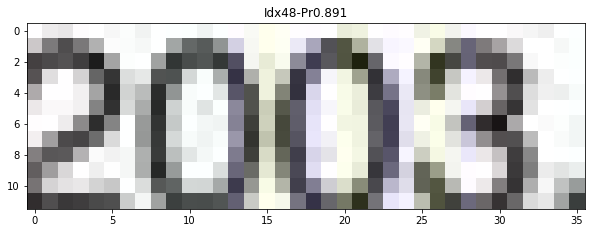

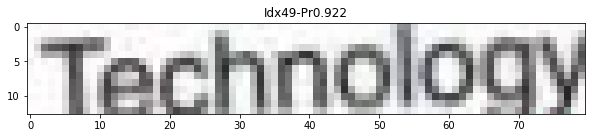

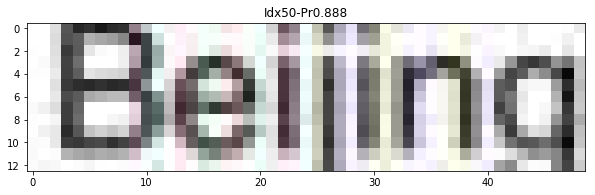

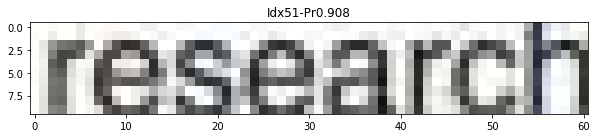

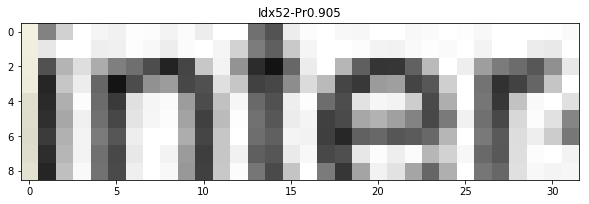

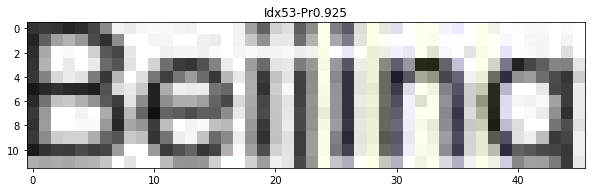

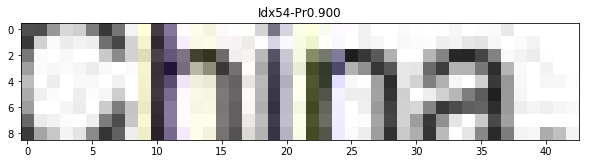

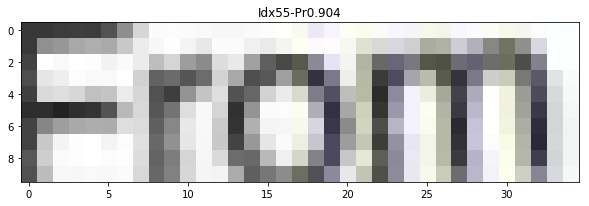

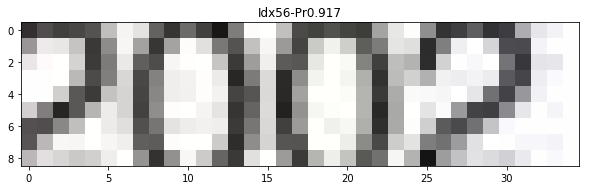

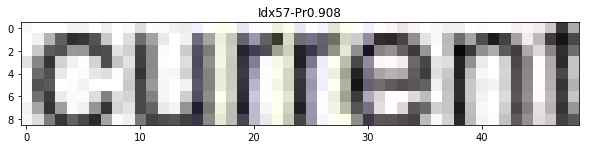

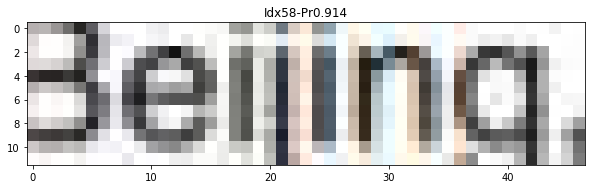

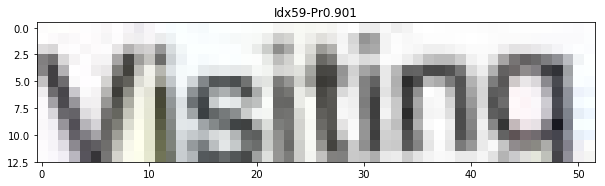

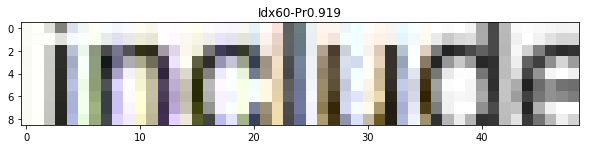

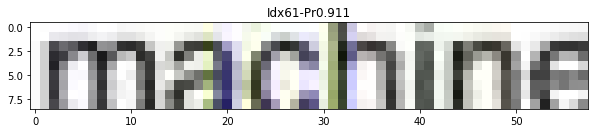

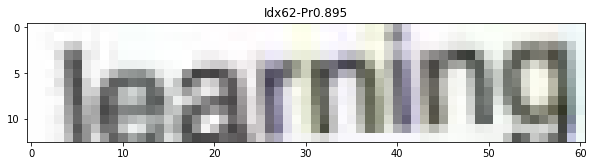

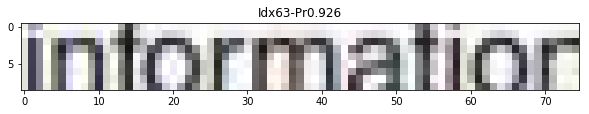

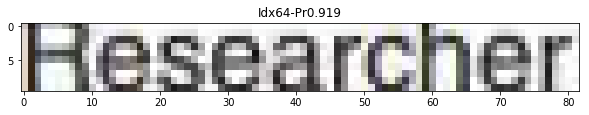

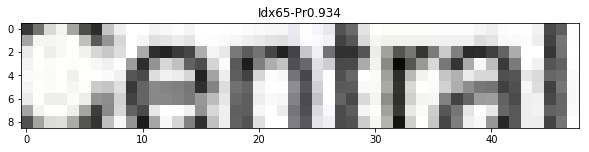

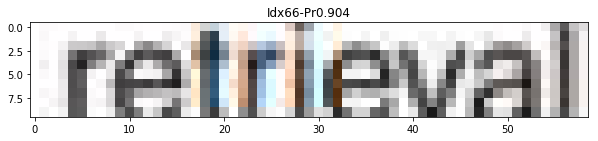

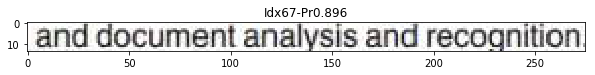

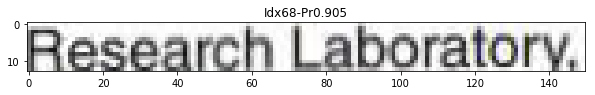

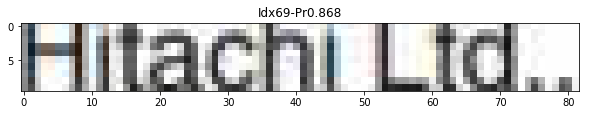

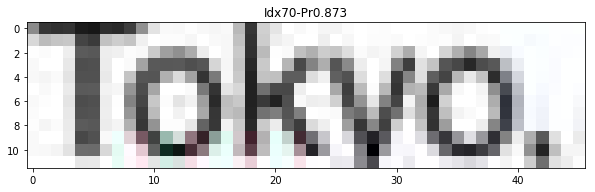

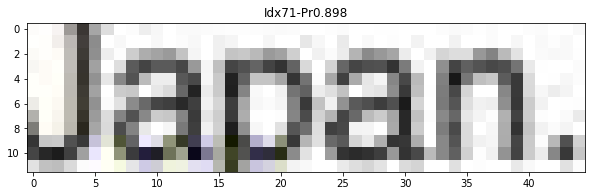

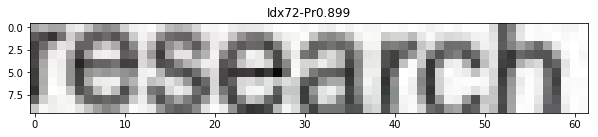

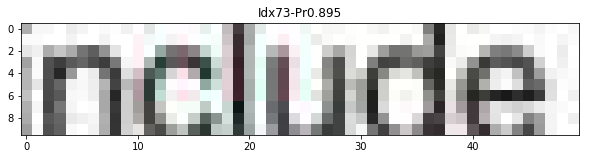

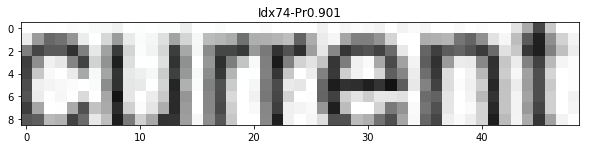

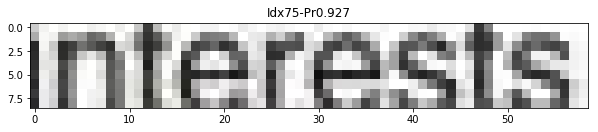

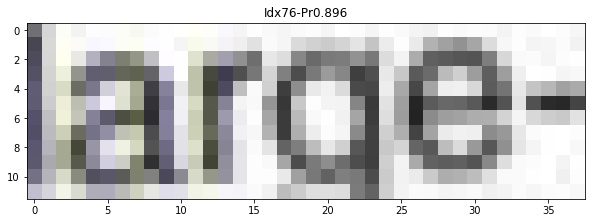

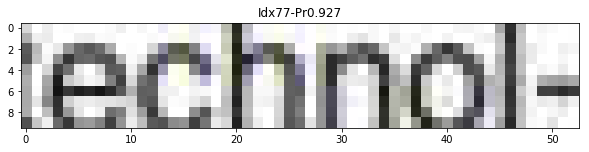

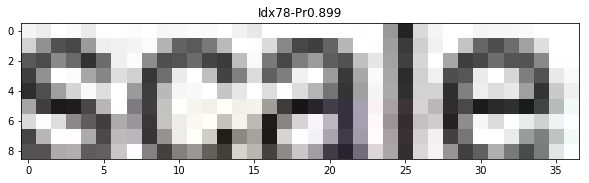

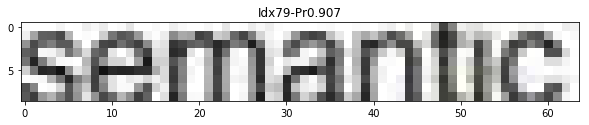

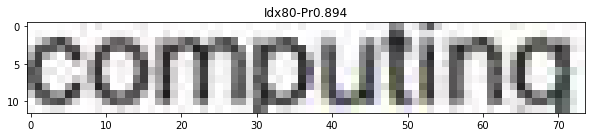

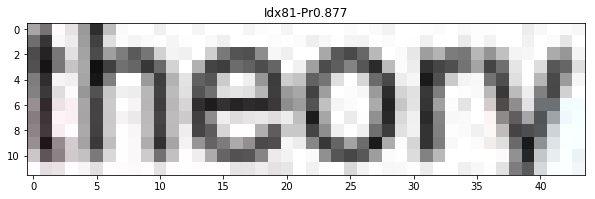

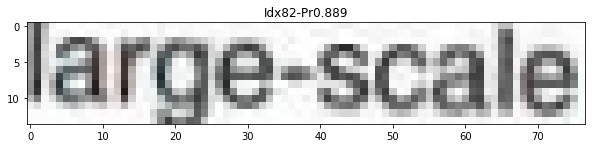

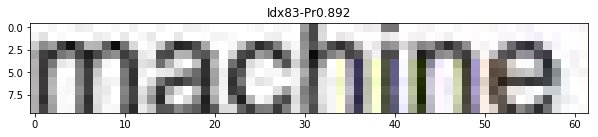

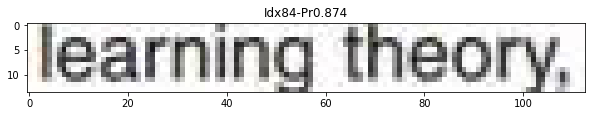

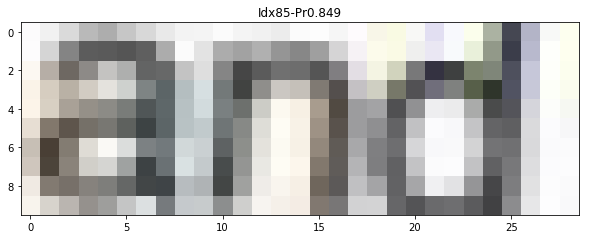

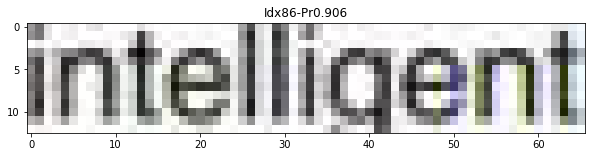

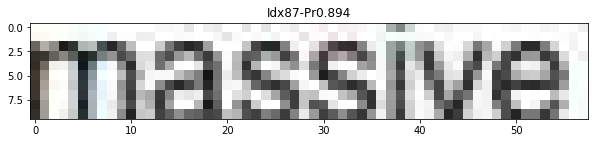

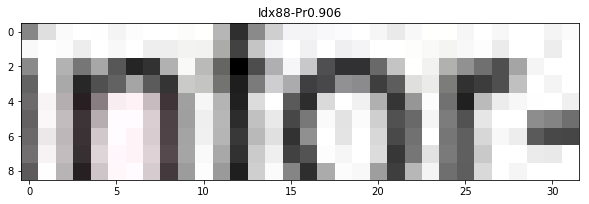

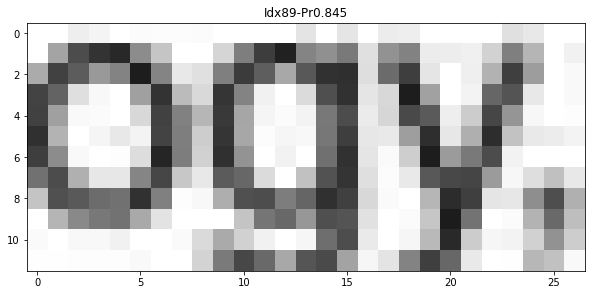

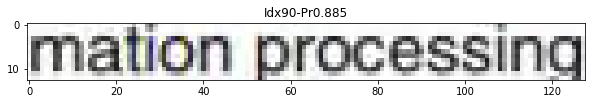

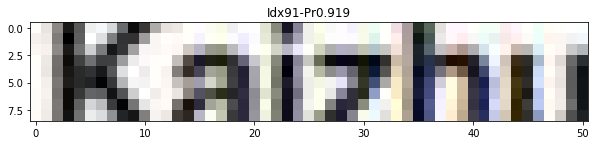

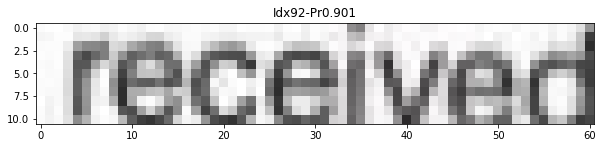

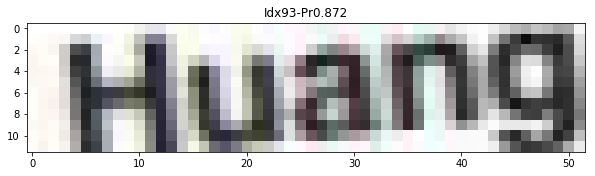

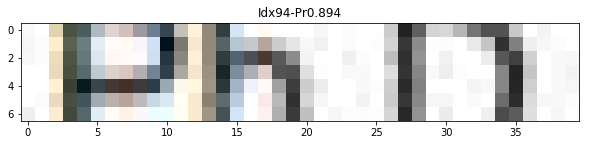

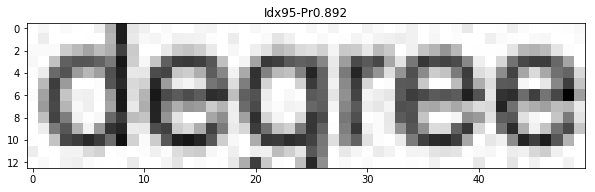

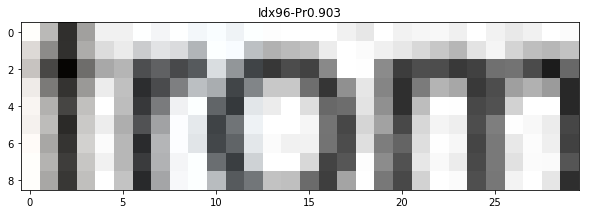

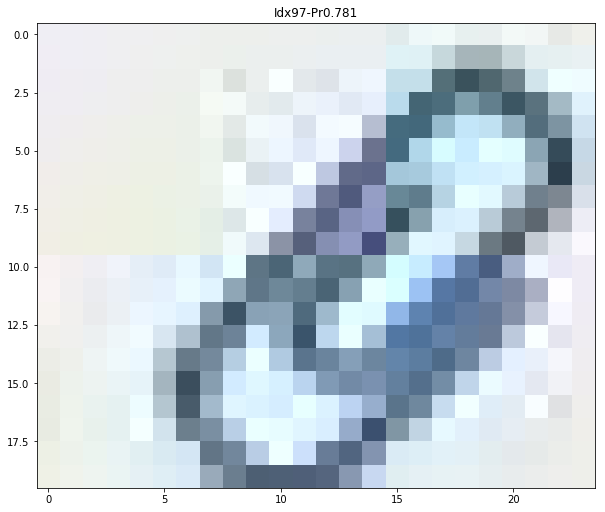

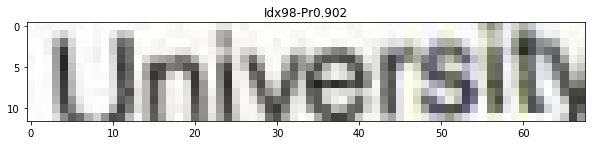

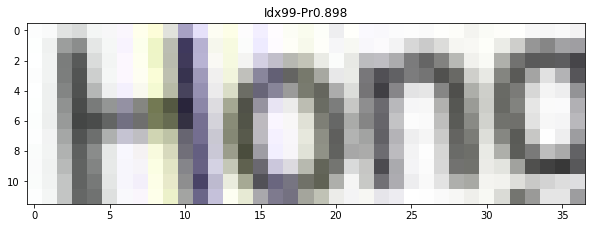

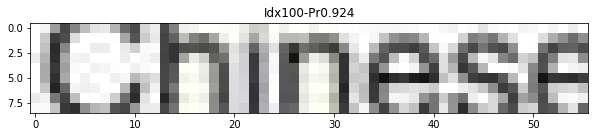

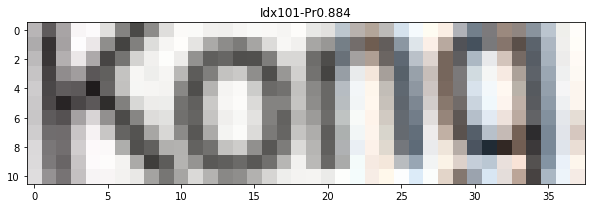

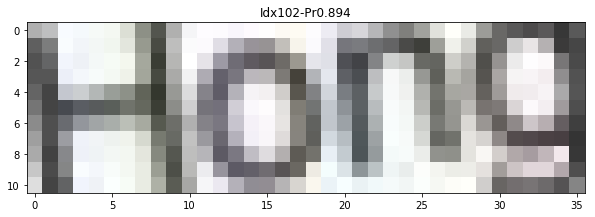

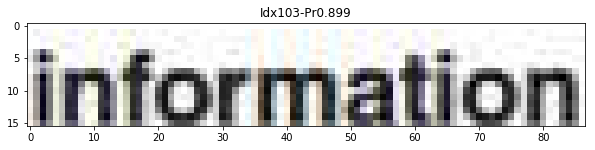

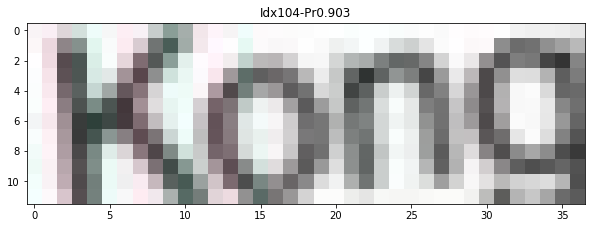

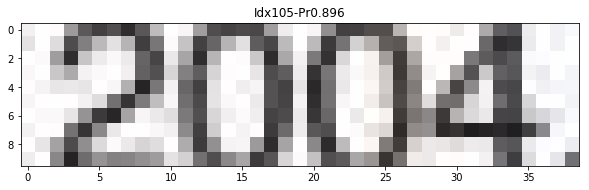

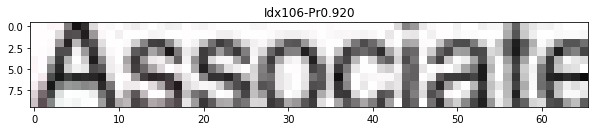

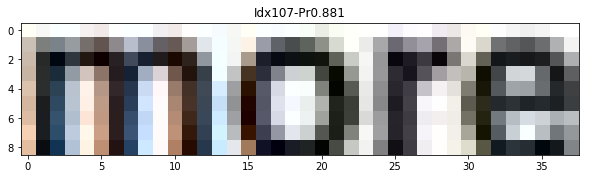

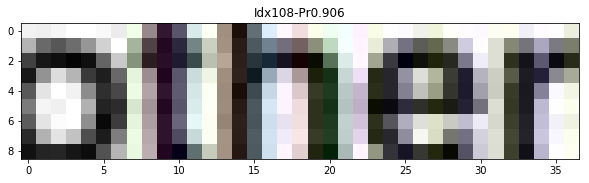

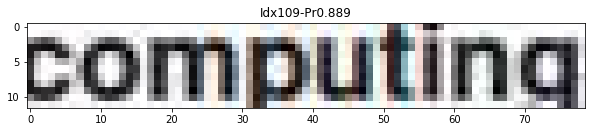

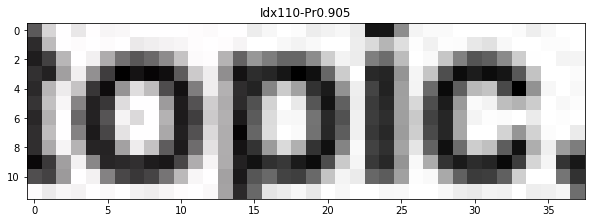

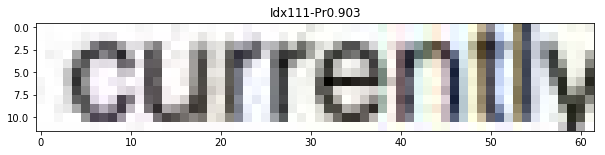

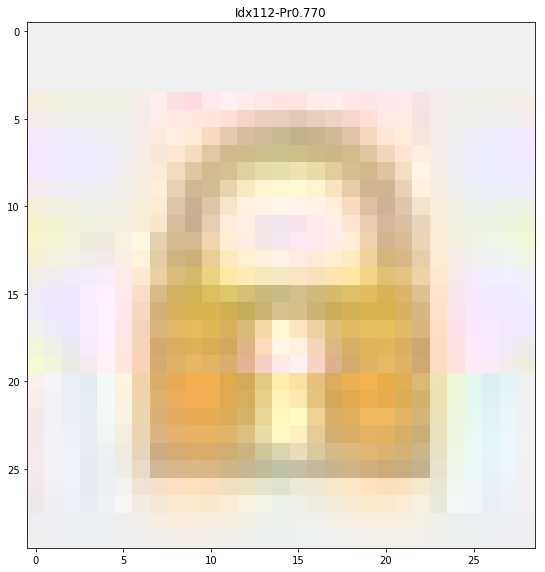

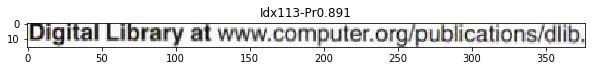

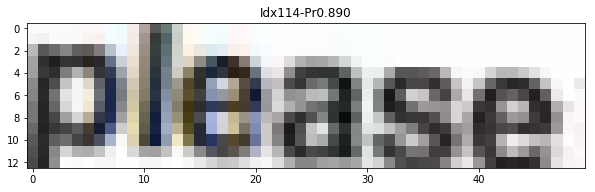

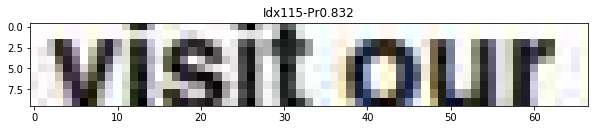

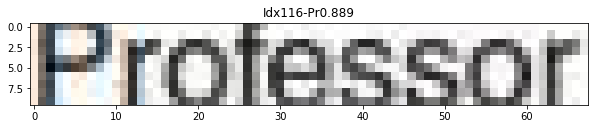

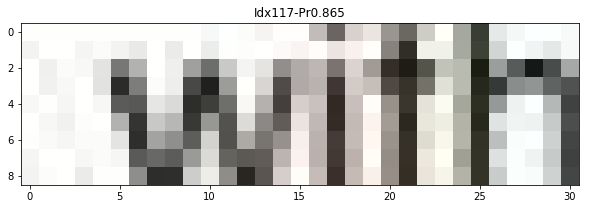

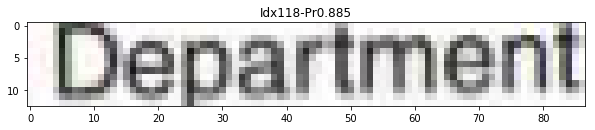

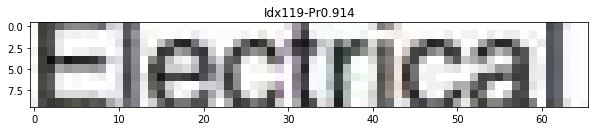

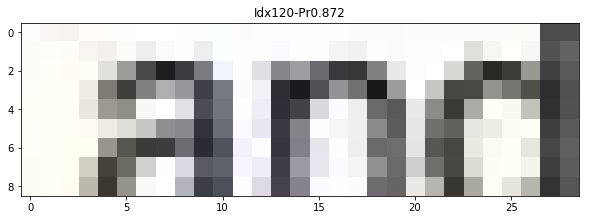

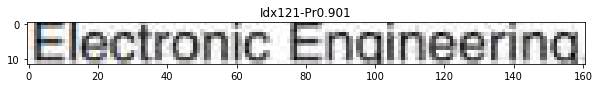

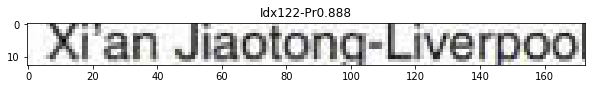

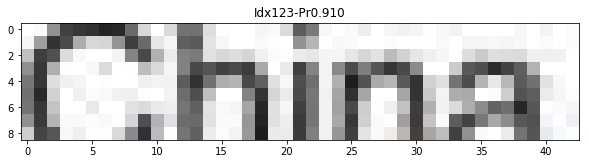

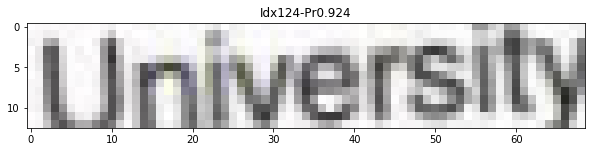

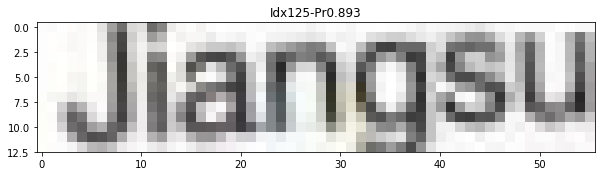

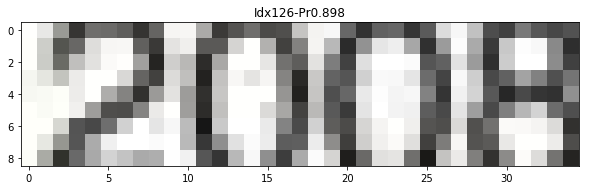

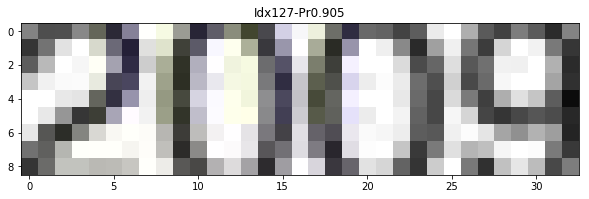

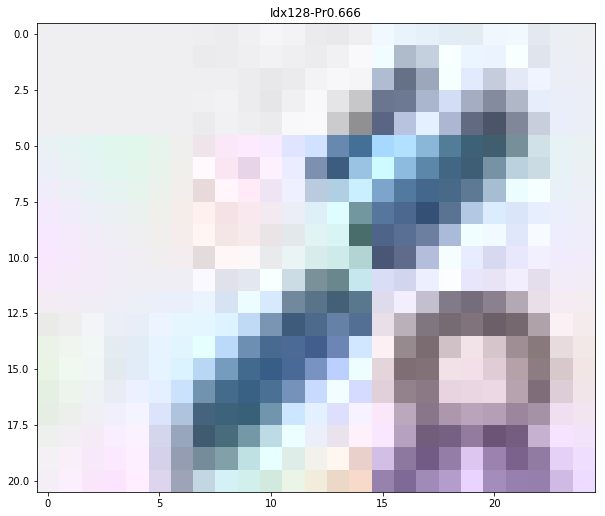

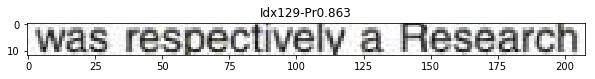

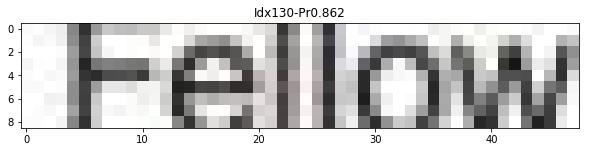

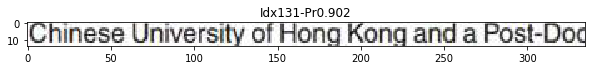

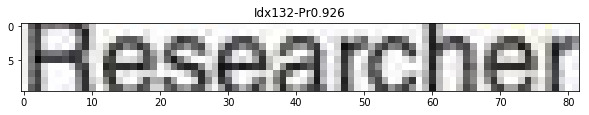

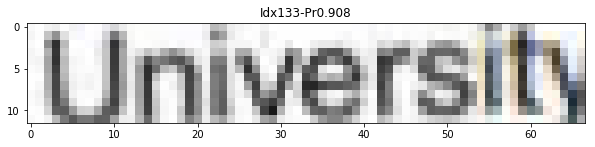

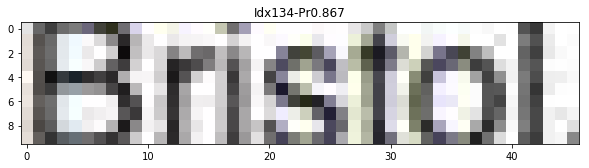

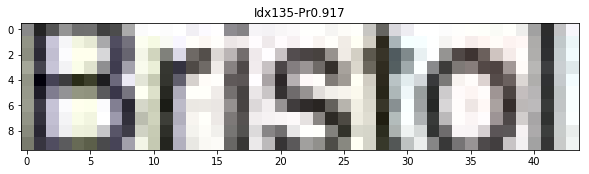

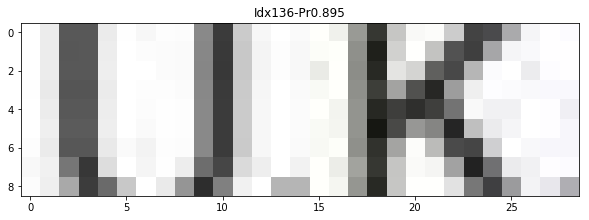

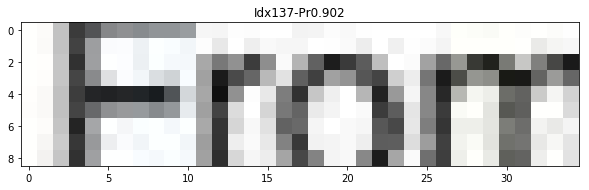

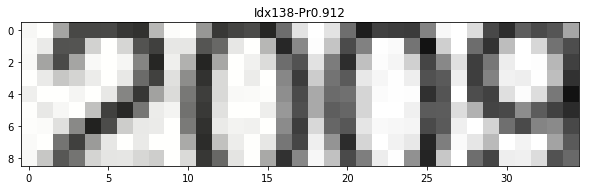

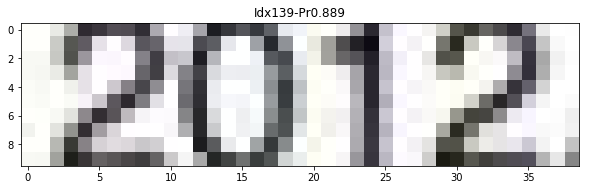

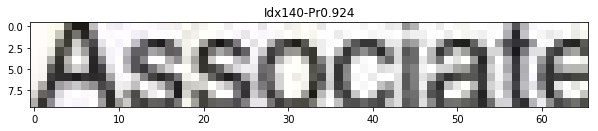

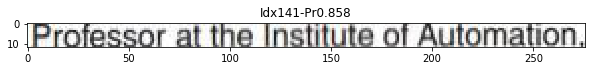

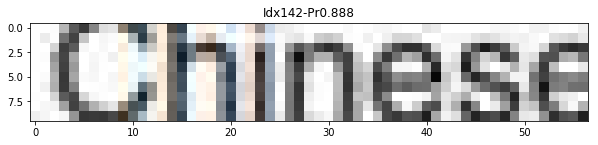

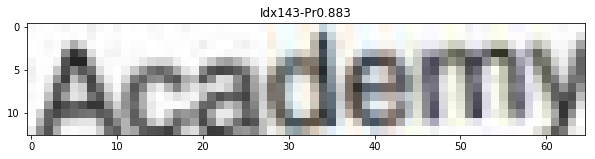

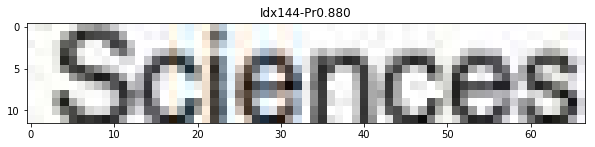

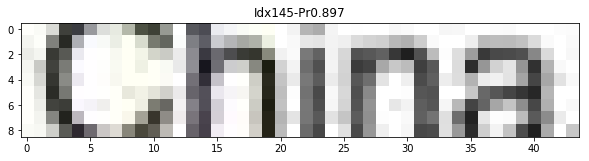

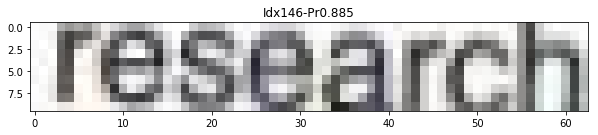

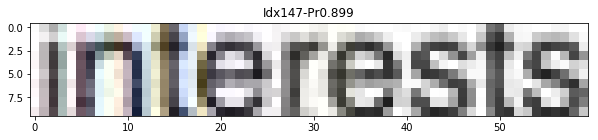

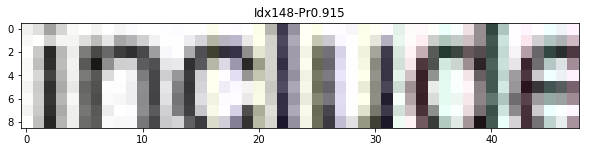

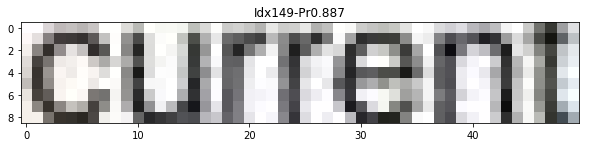

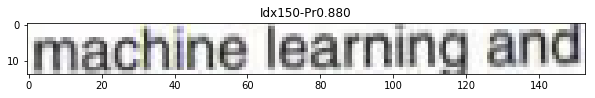

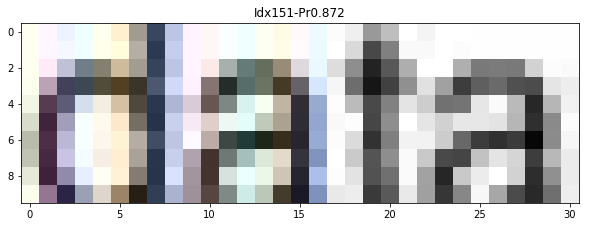

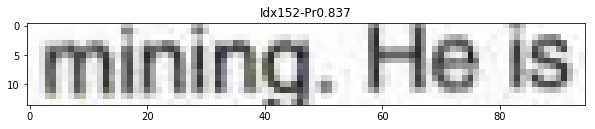

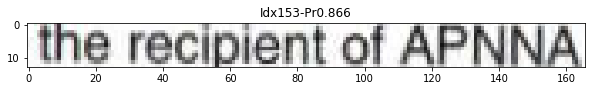

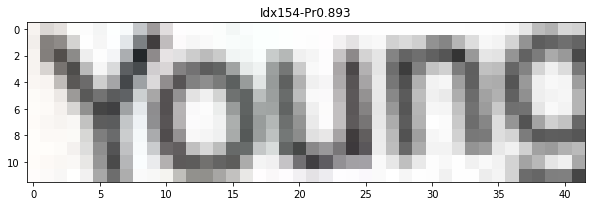

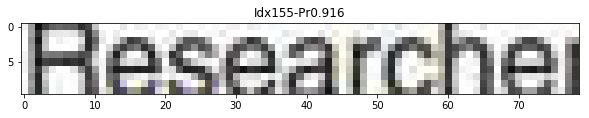

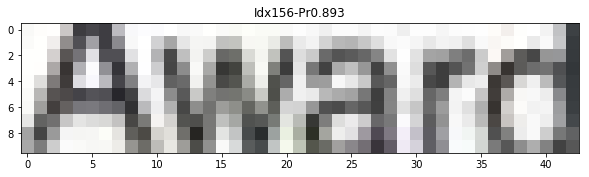

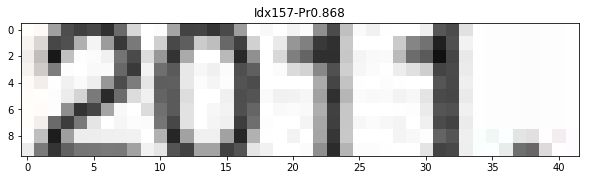

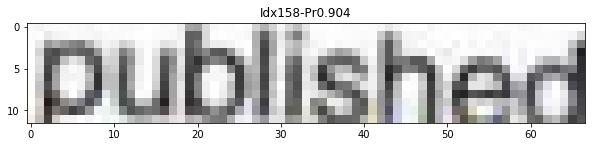

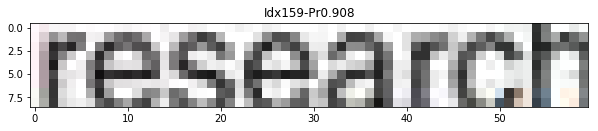

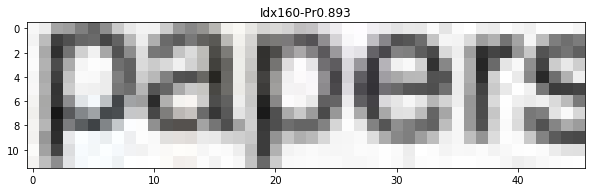

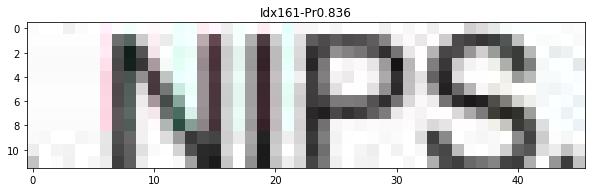

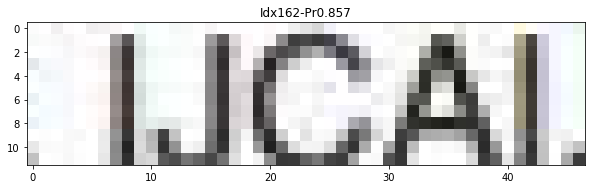

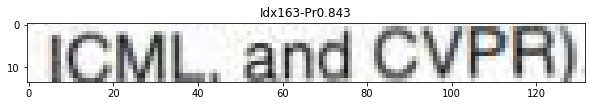

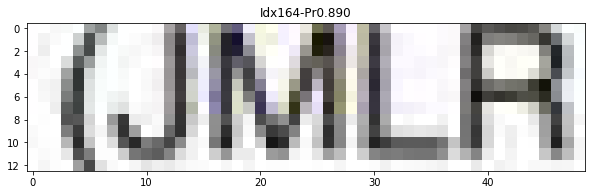

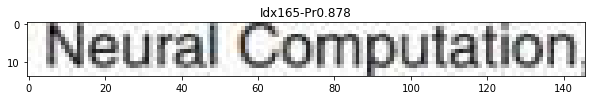

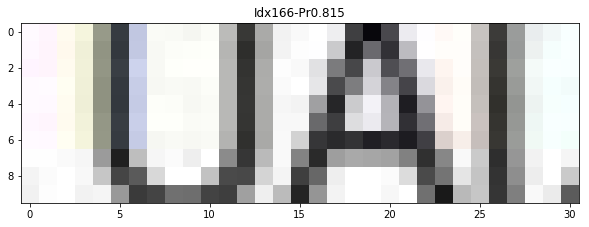

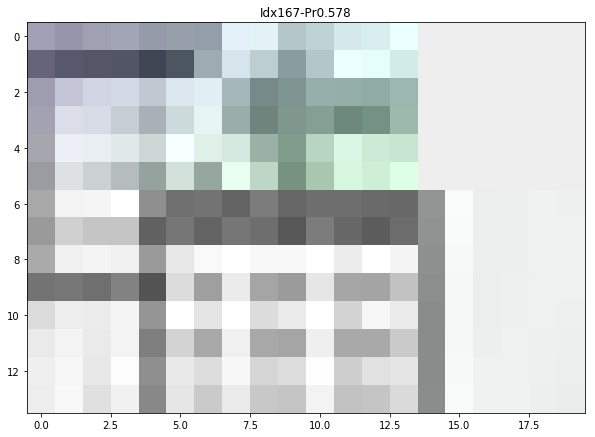

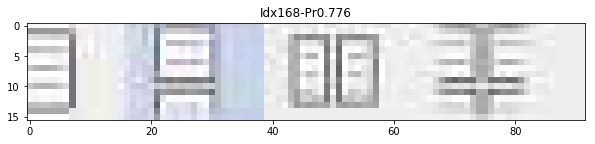

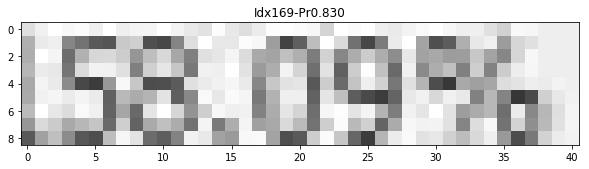

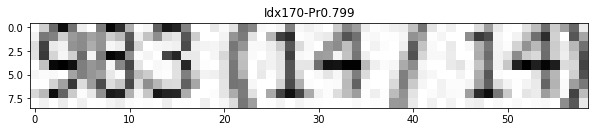

In [464]:
visualize = True
ih, iw = img.shape[:2]
proba_threshold = .55
area_threshold = 256
contrast_threshold = 24
print text_proba_all.shape
#
text_proba = text_proba_minmax( text_proba_all )
script_proba = script_proba_minmax( script_proba_all )
scriptID = decode_scriptID( script_proba )
print script_proba, scriptID
# 3.b sample connected component analysis based decoder
membership = text_proba.argmax( axis = -1 )
regions = bwlabel( membership == 2, neighbors=8 )
if (img.ndim==2) :
    img = np.dstack([img for k in range(3)])
decoded_results = decode_text_bboxes( img, text_proba[...,-1], regions )
print "Total =", len(decoded_results)
# 5. visualize results
if ( visualize ) :
    visualize_text_proba_map( img, text_proba[:ih,:iw], scriptID )
# 6. save detection results 
# modify this section to save additional/different information
header = ','.join([ 'topLeftX', 'topLeftY', 'botRightX', 'botRightY', 'boxProba' ])
det_results = [ header ]
valid_indices = []
for idx, (bbox, proba, wrapped_image) in enumerate( decoded_results ):
    if ( proba < proba_threshold ) :
        print "Reject", idx, "due to low proba,", proba, area, contrast
        continue
    upper_left, upper_right, lower_right, lower_left = bbox
    cnt = np.row_stack([upper_left, upper_right, lower_right, lower_left]) 
    area = cv2.contourArea( cnt )
    if ( area < area_threshold ) :
        print "Reject", idx, "due to small area", proba, area, contrast
        continue
    contrast = np.max( wrapped_image.std(axis=(0,1)) )
    if ( contrast < contrast_threshold ) :
        print "Reject", idx, "due to low contrast", proba, area, contrast
        continue
    upper_left = [ '{:d}'.format(int(val)) for val in upper_left ]
    lower_right = [ '{:d}'.format(int(val)) for val in lower_right ]
    this_line = upper_left + lower_right + [ '{:.3f}'.format(proba) ]
    this_line = ','.join( this_line )
    det_results.append( this_line )
    valid_indices.append(idx)
det_results = '\n'.join( det_results )

valid_results = [decoded_results[k] for k in valid_indices]
visualize_individual_regions( valid_results, 0, 0  )

In [121]:
print script_proba_all

[[ 0.     0.756  0.066  0.033  0.012  0.101  0.032]
 [ 0.     0.758  0.072  0.039  0.011  0.089  0.031]
 [ 0.     0.724  0.165  0.06   0.004  0.027  0.02 ]
 [ 0.     0.237  0.558  0.053  0.007  0.132  0.012]
 [ 0.     0.197  0.067  0.032  0.001  0.691  0.013]
 [ 0.     0.194  0.043  0.032  0.001  0.718  0.013]
 [ 0.     0.317  0.022  0.061  0.001  0.584  0.015]
 [ 0.     0.223  0.042  0.064  0.001  0.656  0.014]
 [ 0.     0.289  0.021  0.058  0.001  0.616  0.015]
 [ 0.     0.313  0.036  0.079  0.001  0.555  0.016]
 [ 0.     0.279  0.046  0.156  0.002  0.5    0.017]
 [ 0.     0.286  0.114  0.139  0.004  0.441  0.017]
 [ 0.     0.234  0.159  0.169  0.008  0.414  0.016]
 [ 0.     0.348  0.161  0.284  0.012  0.176  0.019]
 [ 0.     0.376  0.153  0.187  0.009  0.255  0.02 ]
 [ 0.     0.436  0.237  0.177  0.015  0.111  0.023]
 [ 0.     0.495  0.161  0.211  0.014  0.094  0.025]
 [ 0.     0.615  0.145  0.114  0.012  0.087  0.028]
 [ 0.     0.619  0.165  0.09   0.015  0.082  0.028]
 [ 0.     0.

# Text and scriptID detection for a web image

In [442]:
url

'https://media2.s-nbcnews.com/i/newscms/2018_13/2383341/180331-stephon-clark-protest-ew-755p_bce3a0a92f27d0671f85d727e58139bb.jpg'

In [463]:
url = 'http://www.moremorewin.net/imgserver/imgs/2018/04/12/5ac604cf72833da2501be53369c9d4d7.jpg'
#url = 'https://img.huffingtonpost.com/asset/5a8b21302100003800601b06.jpeg?ops=scalefit_600_noupscale' # ok, but not too good
#url = 'http://www.slate.com/content/dam/slate/blogs/browbeat/2017/01/20/the_best_protest_signs_from_donald_trump_s_inauguration/c2n7dp9wqaiafly_1.jpg.CROP.promo-xlarge2.jpg'
#url = 'https://media2.s-nbcnews.com/i/newscms/2018_13/2383341/180331-stephon-clark-protest-ew-755p_bce3a0a92f27d0671f85d727e58139bb.jpg'
#url = 'https://www.euractiv.com/wp-content/uploads/sites/2/2017/12/Protest-in-Kyiv-800x450.jpg' # russian
#url = 'http://www.theveganwoman.com/wp-content/uploads/2015/07/Amit-4.jpg' # hebrew+arbic
#url = 'https://i.ytimg.com/vi/vqT6tIhCGIM/hqdefault.jpg' #good， video

#url = 'https://assets.forwardcdn.com/images/cropped/untitled-32-2-1486157107.jpg' # good hebrew

#url = 'https://www.birchbox.com/images/uploads/M_March_HairStyle_Article_F.jpg'
url = 'https://i.ytimg.com/vi/gk42gK8BYao/maxresdefault.jpg'
#url = 'https://allisonshea.files.wordpress.com/2010/05/jennifer-ross-letter.jpg' # ok, large number of regions
##url = 'https://blog.prepscholar.com/hs-fs/hubfs/body_harvardapp_teacher1-3.png?t=1523211078966&width=737&height=997&name=body_harvardapp_teacher1-3.png'

#url = 'https://koreanclassmassive.files.wordpress.com/2012/02/dirty-korean-language-book-5-e1358099028906.jpg' # korean textbook, good
#url = 'http://www.silver-psy.com/wp-content/uploads/2015/06/IMG_8056.jpg' # russian dilopma
#url = 'http://kinoroom.club/wp-content/uploads/2018/01/sears-gift-receipt-image-images-sears-gift-receipt-policy.jpg'
#url = 'http://savebastionpoint.org/wp-content/uploads/2010/11/Bastion-Bottom-Line-cartoon.jpg' # good/comic
#url = 'http://pbs.twimg.com/media/DK53DFGXUAAAmb1.jpg'
#url = 'http://business.rea.ru/images/licence_certificates/rea_licence.jpg'
#url = 'https://cdn.cnn.com/cnnnext/dam/assets/120612025350-vladimir-putin-protest-russia-horizontal-large-gallery.jpg' # ok
#url = 'http://www.familytree.com/wp-content/uploads/2014/01/Scanned-doc-LewkowiczLudwig-52.jpg'
#url = 'http://www.xinhuanet.com/english/2018-02/20/CnybnyE005001_20180220_NYMFN0A002_11n.jpg'
#url = 'https://www.ctvnews.ca/polopoly_fs/1.134784.1337371333!/httpImage/image._gen/derivatives/landscape_620/image.'
#url = 'http://i.epochtimes.com/assets/uploads/2015/11/151119002624836-600x400.jpg' # good
#url = 'http://www.people.com.cn/mediafile/pic/20141207/13/9028967040529988685.jpg' # ok
#url = 'https://static.timesofisrael.com/www/uploads/2016/08/APTOPIX-Mideast-Egypt_Horo-1.jpg' # good
img, text_proba_all, script_proba_all = lazy_decoder( url,
                                                      textDet_model,
                                                      scriptID_model )

now using rescale factor = 0.1 72 128
now using rescale factor = 0.239473684211 172 306
now using rescale factor = 0.378947368421 272 485
now using rescale factor = 0.518421052632 373 663
now using rescale factor = 0.657894736842 473 842
now using rescale factor = 0.797368421053 574 1020
now using rescale factor = 0.936842105263 674 1199
now using rescale factor = 1.07631578947 774 1377
now using rescale factor = 1.21578947368 875 1556
now using rescale factor = 1.35526315789 975 1734
now using rescale factor = 1.49473684211 1076 1913
now using rescale factor = 1.63421052632 1176 2091
now using rescale factor = 1.77368421053 1277 2270
now using rescale factor = 1.91315789474 1377 2448
now using rescale factor = 2.05263157895 1477 2627
now using rescale factor = 2.19210526316 1578 2805
now using rescale factor = 2.33157894737 1678 2984
now using rescale factor = 2.47105263158 1779 3162
now using rescale factor = 2.61052631579 1879 3341
now using rescale factor = 2.75 1980 3520
now using

In [134]:
img.shape

(168, 300)

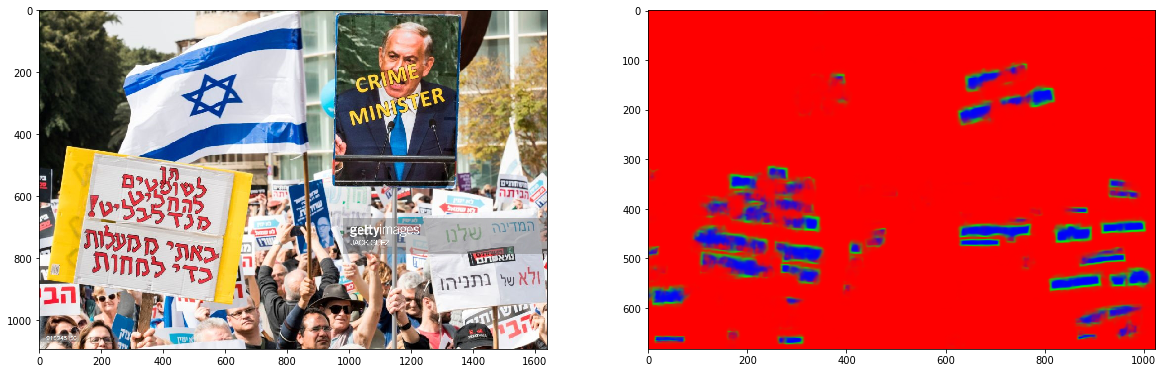

In [100]:
idx = 15
pyplot.figure( figsize=(20,10))
pyplot.subplot(121)
pyplot.imshow( cv2.resize(img, None, fx=(1+idx)/10., fy=(1+idx)/10., interpolation=cv2.INTER_AREA ) )
pyplot.subplot(122)
pyplot.imshow( text_proba_all[idx] )

# Text and scriptID detection for a local image

1652 1276
INFO: skip 78 proba = 0.382915 area = 6
INFO: skip 79 proba = 0.342357 area = 3
INFO: skip 80 proba = 0.387955 area = 13
INFO: skip 81 proba = 0.342428 area = 7
INFO: skip 82 proba = 0.396578 area = 16


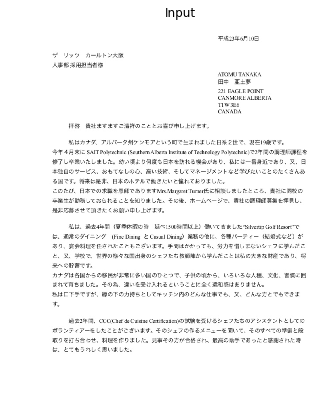

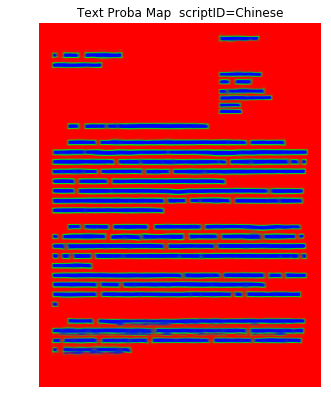

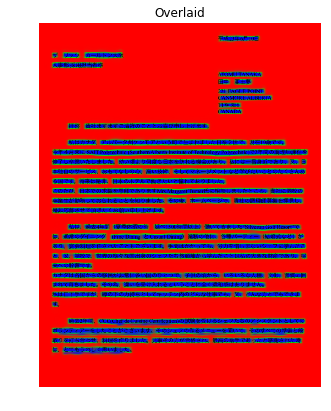

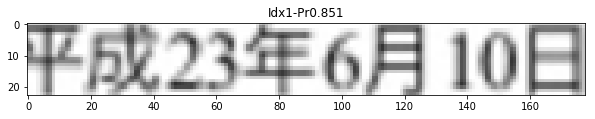

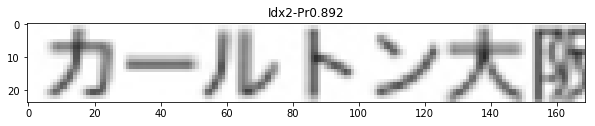

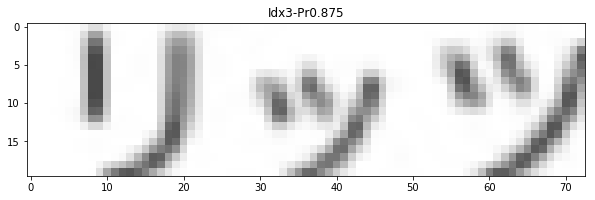

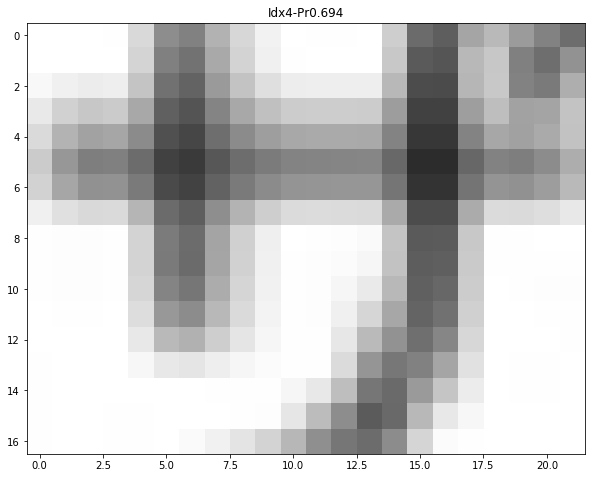

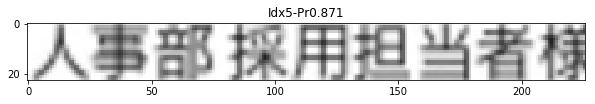

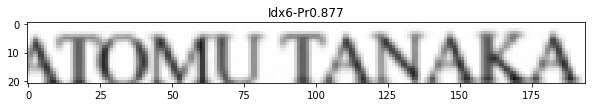

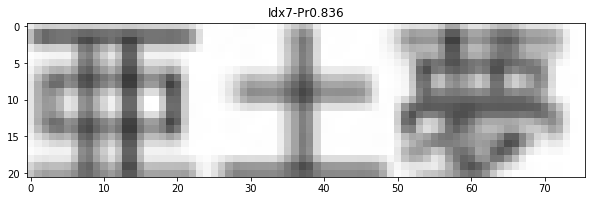

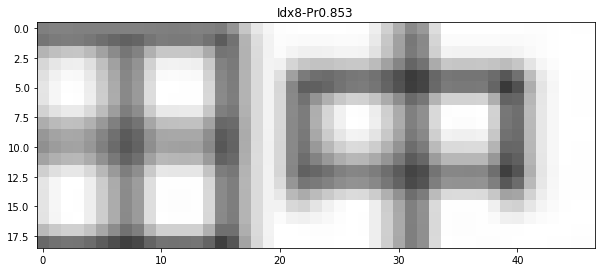

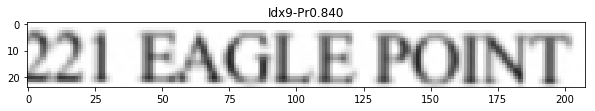

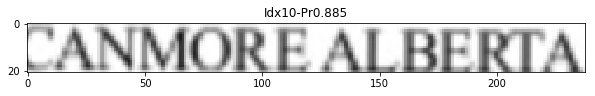

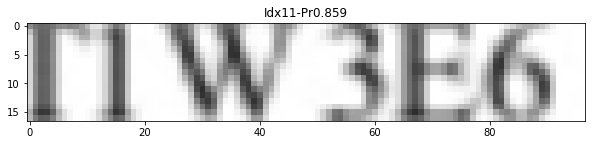

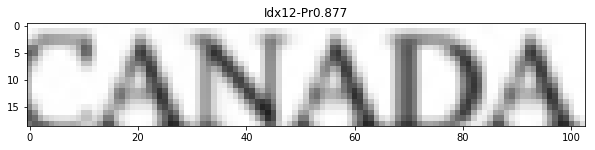

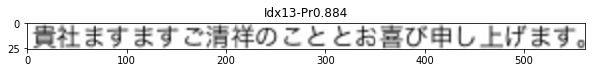

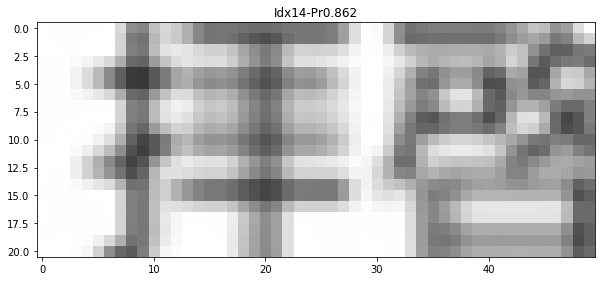

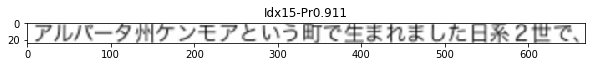

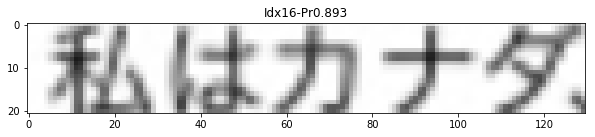

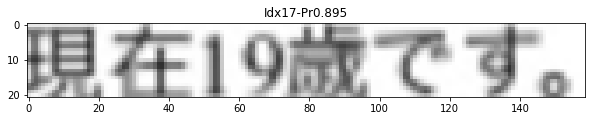

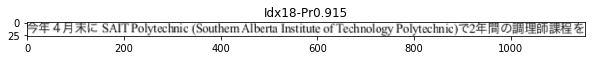

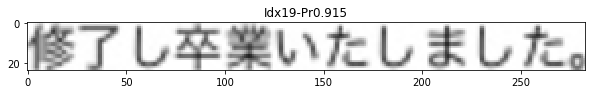

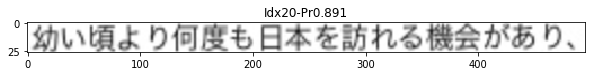

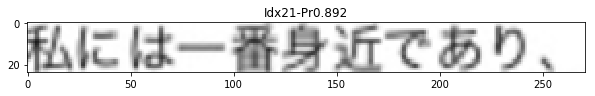

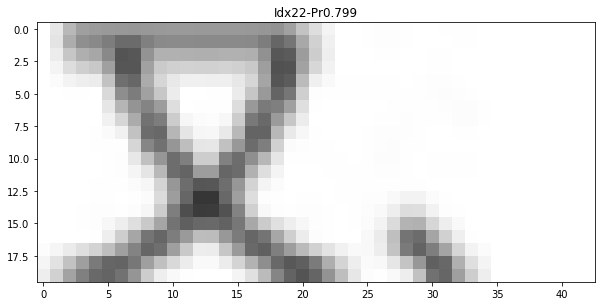

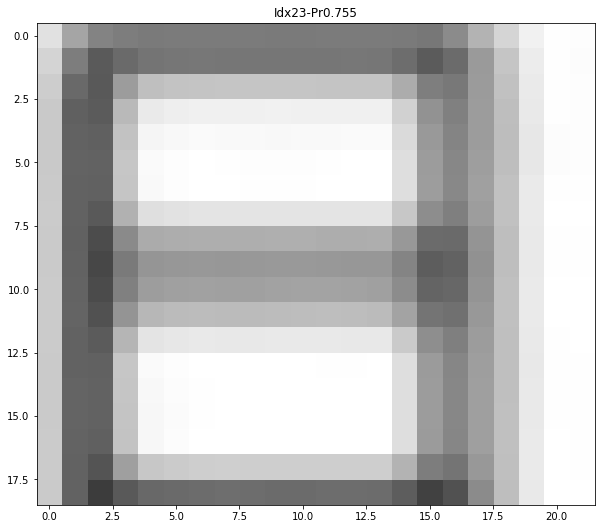

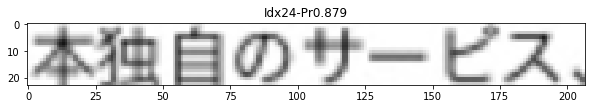

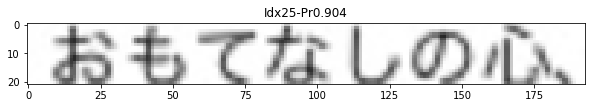

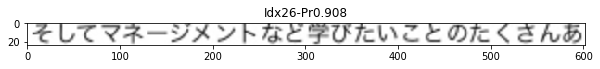

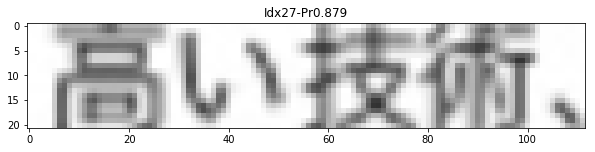

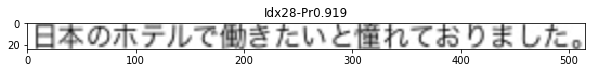

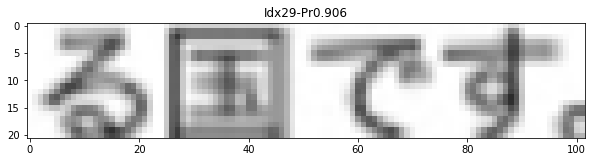

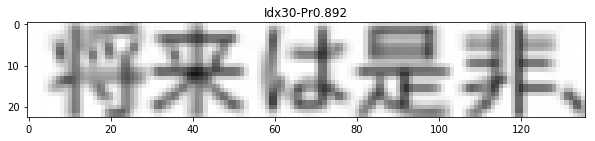

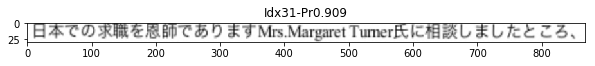

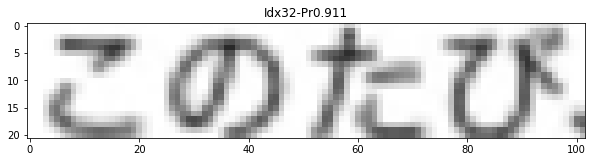

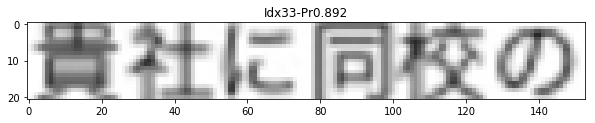

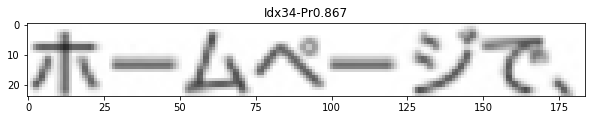

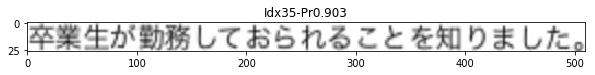

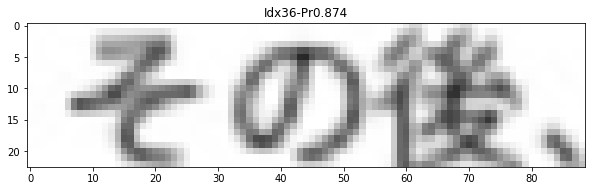

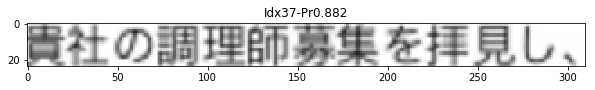

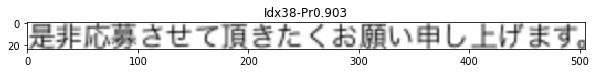

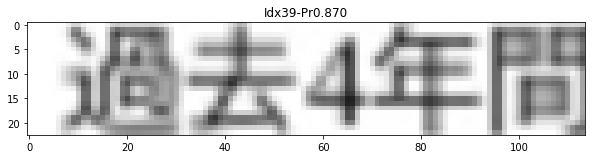

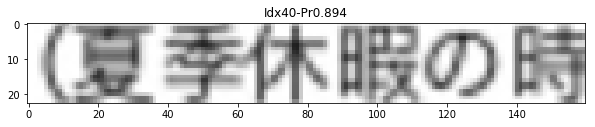

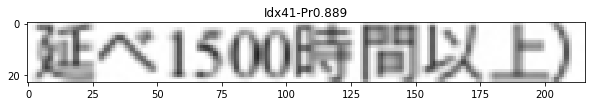

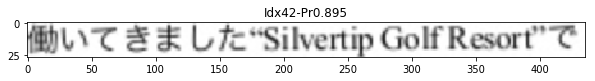

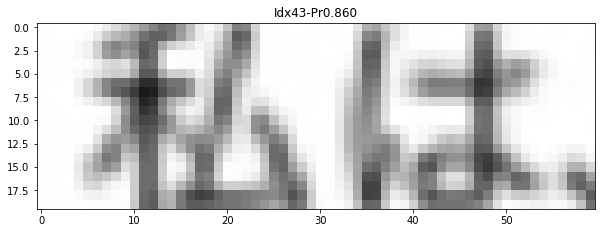

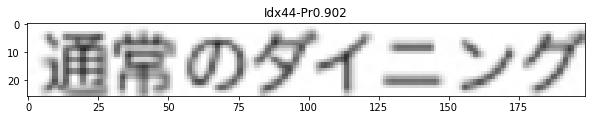

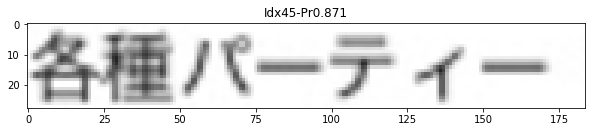

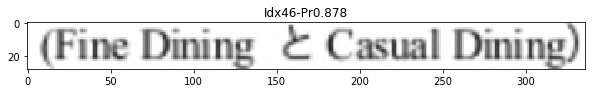

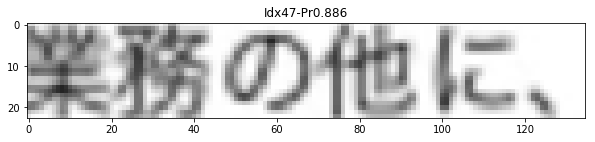

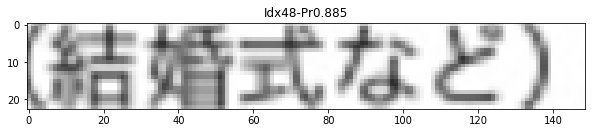

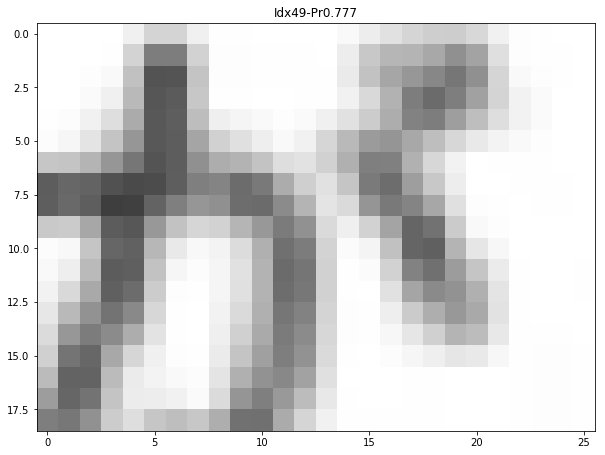

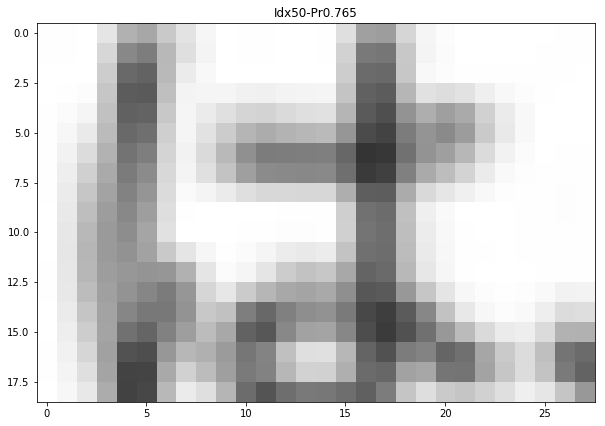

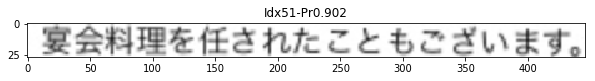

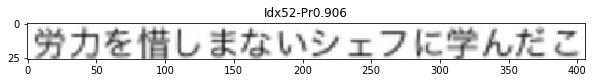

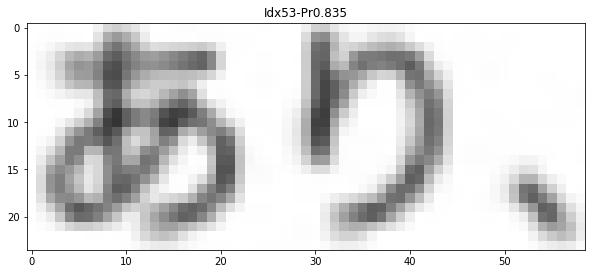

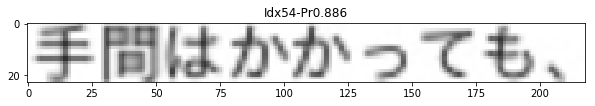

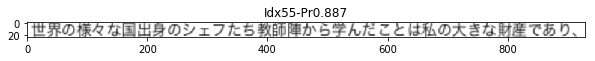

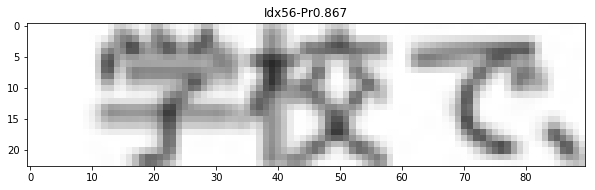

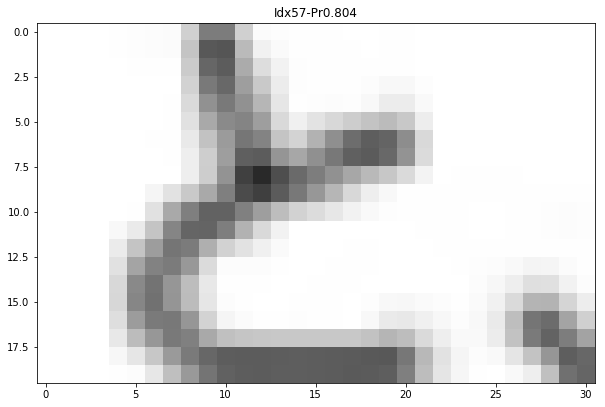

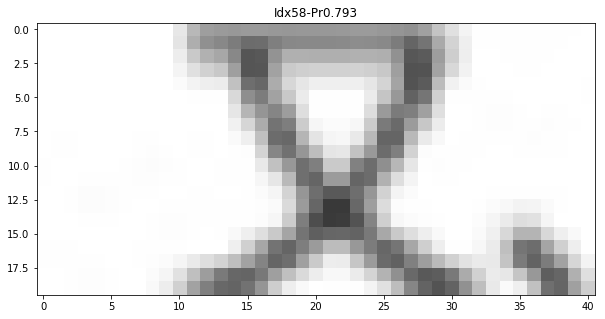

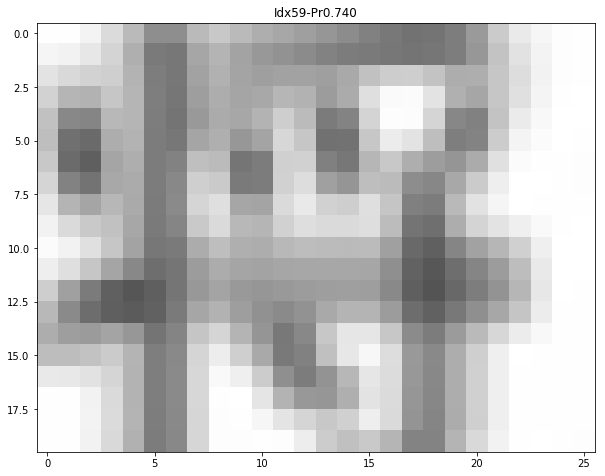

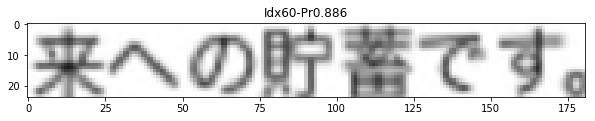

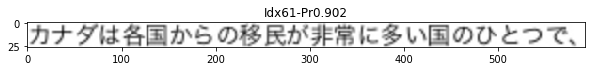

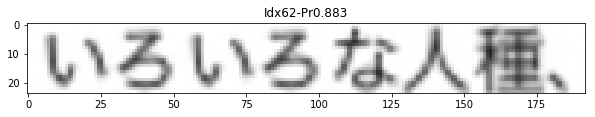

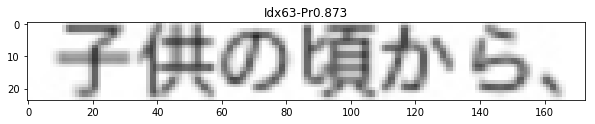

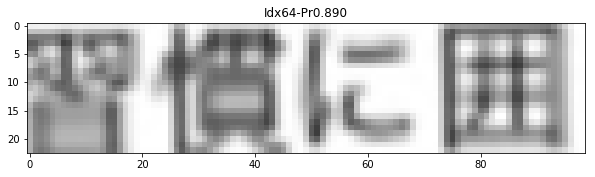

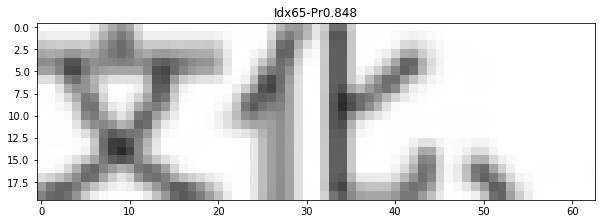

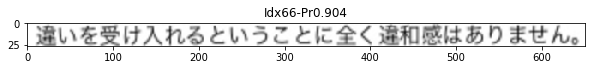

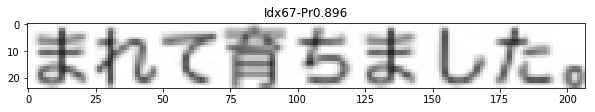

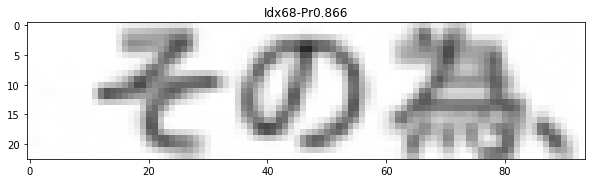

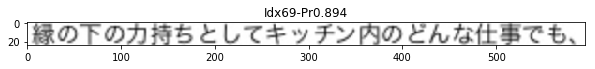

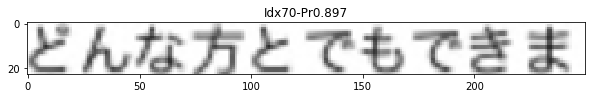

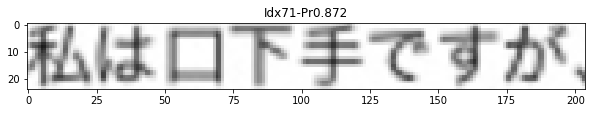

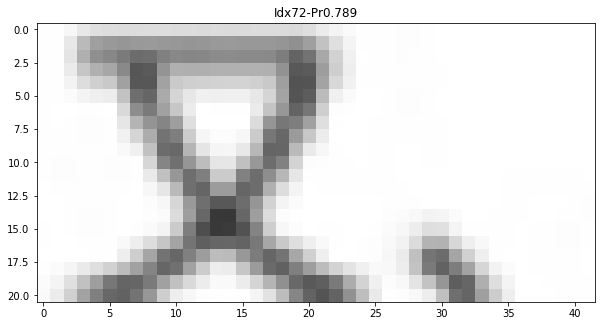

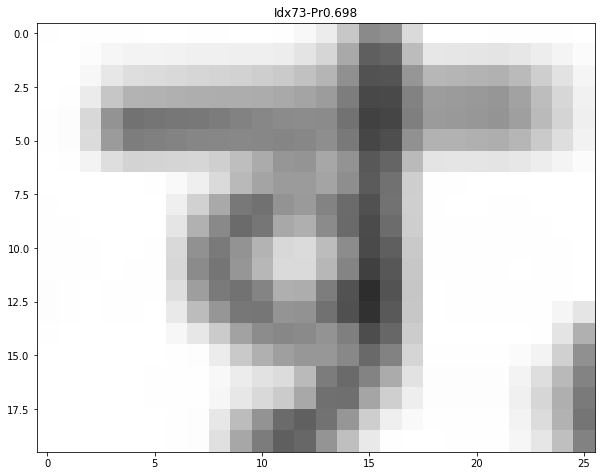

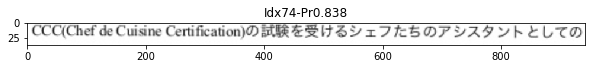

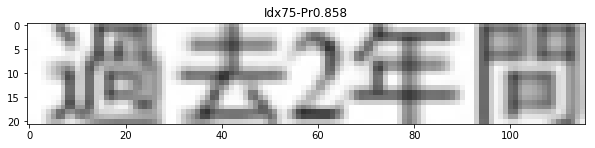

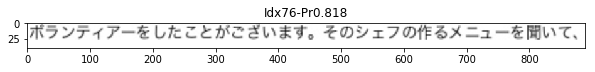

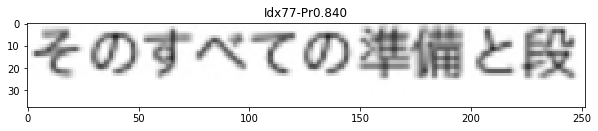

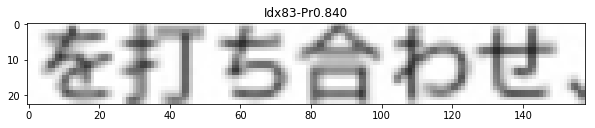

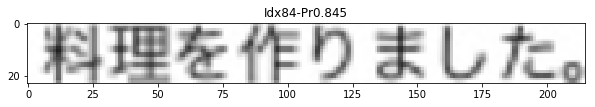

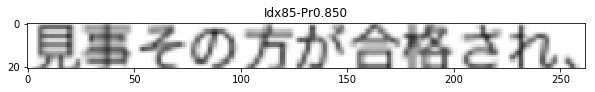

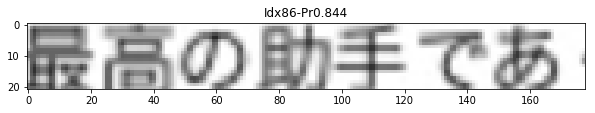

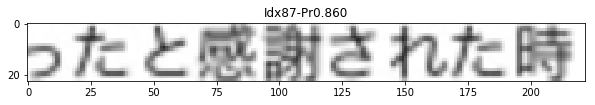

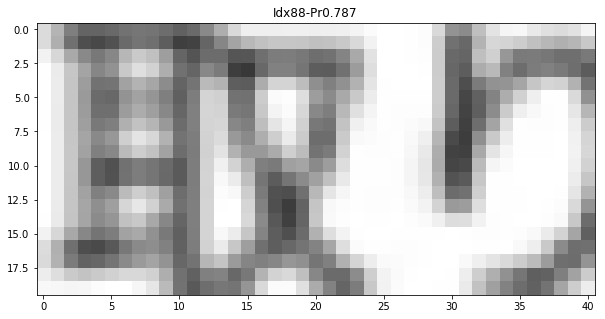

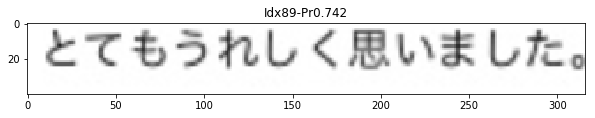

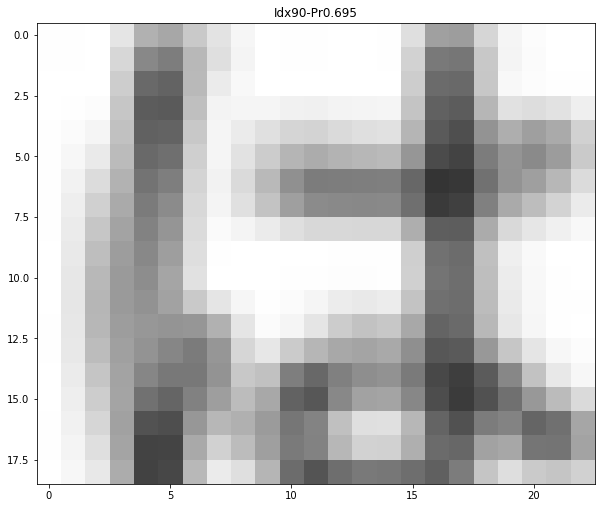

In [451]:
file_path = os.path.join( data_dir, 'JAP_atomu-tanaka-japanese-cover-letter-1-638.jpg' )
det_results = simple_decoder( file_path,
                              textDet_model,
                              scriptID_model,
                              resize_factor = 2,
                              proba_threshold = .5,
                              area_threshold = 100.,
                              visualize = True )

# Remark

Though you see fancy perspective transform based corrections for text regions, they are not included in `det_results`.  Actually, `det_results` only include rectangular text bounding boxes. 